In [2]:
!nvidia-smi --list-gpus

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6ddc30e5-b8d8-559e-ff49-5c9690f2f22f)


In [44]:
!pip install --upgrade pip
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install tensorflow_addons

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!mkdir cots-zip && \
    kaggle competitions download -c tensorflow-great-barrier-reef -p cots-zip/

!mkdir -p input/tensorflow-great-barrier-reef && \
    ls cots-zip/ && \
    unzip cots-zip/tensorflow-great-barrier-reef.zip -d input/tensorflow-great-barrier-reef

In [6]:
import os
import random
import math
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

BASE_DIR = Path('./input/tensorflow-great-barrier-reef/')

def seed_everything(seed=685055545):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '0' # sad

seed_everything()

mean = [0.22160156, 0.60840114, 0.65382148]
std = [0.17279742, 0.17416202, 0.16197856]

GPUS = tf.config.list_physical_devices('GPU')
DATA_FORMAT = 'channels_first' if GPUS else 'channels_last'


# For debugging :_)
def build_graph(model):
    x = keras.Input(shape=(3, 1280, 1280))
    return keras.Model(inputs=[x], outputs=model.call(x))

# Architecture

Originally, I was gonna go the YOLOv4 route until I discovered YOLOR. Basically sounds like a free performance boost and an accuracy boost, so why not rewrite the whole thing after I already had a basic YOLOv4 implementation working??

The resulting layer definitions, data loading scheme, and training strategy below are an unholy translation of Pytorch to Tensorflow based on the following repos (which seem loosely based on a common source code):

- [pytorch-YOLOv4](https://github.com/Tianxiaomo/pytorch-YOLOv4)
- [yolor](https://github.com/WongKinYiu/yolor)

These libraries use YAML definitions and a parser to dynamically define their architecture. I opted to write out the code manually for a few reasons:

- Better for learning...
  - I had to actually understand the crazy 1.5K line YAML configuration to recreate their network.
  - I'll get a better intuition for how to train similar networks in the future.
  - I'll get more intuition for important object detection techniques like anchor boxes and non-max suppression.
- Performance should be a bit better...
  - I think there will be more room for (free) optimization without having to use complicated routing mechanisms to translate skip connections and concatenations from the config file.
- Eligibility for the TensorFlow performance prize.
  - Why not?

------

**Side Note:** Thanks TensorFlow for making it impossible to easily test my algorithm on CPU by not supporting NCHW in CPU convolutions. I really like using my GPU quota for basic sanity testing... What? I'm not jaded, that's preposterous.

In [7]:
def mish(x):
    return tfa.activations.mish(x)

def act(string):
    if not string:
        return None
    elif string == 'mish':
        return mish
    elif string == 'leaky':
        return L.LeakyReLU(alpha=0.1)
    else:
        return L.Activation(string)
    

class ConvBnAct(keras.Model):
    
    def __init__(self, out_channels, kernel_size, stride,
                 activation='mish',
                 bias=False,
                 use_bn=True,
                 bias_initializer='zeros',
                 data_format='channels_last'
                ):
        super().__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.use_bias = bias
        self.data_format = data_format
        self.bias_init = bias_initializer
        
        if activation and not isinstance(activation, str):
            raise ValueError('Only string activations supported!')
        else:
            # Assume its a layer or None.
            self.activation = act(activation)
            self.act_type = activation
        
        bn_axis = 1 if data_format == 'channels_first' else -1
        
        self.batch_norm = L.BatchNormalization(
            axis=bn_axis,
            momentum=0.03,
            epsilon=0.0001,
        ) if use_bn else None
    
    def build(self, input_shape):
        kernel_init = keras.initializers.HeUniform()
        self.conv = L.Conv2D(
            self.out_channels,
            self.kernel_size,
            input_shape=input_shape[1:],
            padding='same',
            strides=self.stride,
            activation=None,
            use_bias=self.use_bias,
            data_format=self.data_format,
            kernel_initializer=kernel_init,
            kernel_regularizer=keras.regularizers.l2(5e-4),
            bias_initializer=self.bias_init,
            bias_regularizer=keras.regularizers.l2(5e-4),
        )
    
    def call(self, inputs, training=False):
        x = self.conv(inputs)
        
        if self.batch_norm:
            x = self.batch_norm(x, training=training)
        
        if self.activation:
            x = self.activation(x)
        
        return x
    
    def get_config(self):
        return { 
            'out_channels': self.out_channels,
            'kernel_size': self.kernel_size,
            'stride': self.stride,
            'activation': self.act_type,
            'use_bn': self.batch_norm is not None,
            'bias': self.use_bias,
            'data_format': self.data_format,
            'bias_initializer': self.bias_init,
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


def demo_conv():
    input_shape = (4, 3, 10, 10) if DATA_FORMAT == 'channels_first' else (4, 10, 10, 3)
    cbna = ConvBnAct(6, 3, stride=(1, 1), activation='leaky', data_format=DATA_FORMAT)
    inputs = tf.random.normal(input_shape)
    cbna(inputs, training=False) # To initialize the architecture outside the perf test.
    
    output = None
    start = time.time()
    for _ in range(10):
        output = cbna(inputs, training=False)
    
    duration = (time.time() - start) * 1000
    print('Took:', duration, 'msec')
    print(output[0, 0, 0])
    print(cbna.layers)

# demo_conv()

In [8]:
# Keep as layer since this is a functional layer (nothing trainable).
class Upsample(L.Layer):
    
    def __init__(self, data_format='channels_last'):
        super().__init__()
        self.data_format = data_format
    
    def call(self, x, target_size, training=False):
        shape = K.shape(x)
        
        is_channels_first = self.data_format == 'channels_first'
        
        if is_channels_first:
            target_h, target_w = target_size[2], target_size[3]
            b, c, h, w = shape[0], shape[1], shape[2], shape[3]
            out_size = tf.stack((b, c, target_h, target_w))
        else:
            target_h, target_w = target_size[1], target_size[2]
            b, h, w, c = shape[0], shape[1], shape[2], shape[3]
            out_size = tf.stack((b, target_h, target_w, c))
        
        if training:
            if is_channels_first:
                resize_size = out_size[2:]
                x = tf.transpose(x, [0, 2, 3, 1])
                x = tf.image.resize(x, resize_size, method='nearest')
                return tf.transpose(x, [0, 3, 1, 2])
            else:
                resize_size = out_size[1:3]
                return tf.image.resize(x, resize_size, method='nearest')
        else:
            if is_channels_first:
                out = tf.reshape(x, (b, c, h, 1, w, 1))
                out = tf.broadcast_to(out, (b, c, h, target_h // h, w, target_w // w))
            else:
                out = tf.reshape(x, (b, h, 1, w, 1, c))
                out = tf.broadcast_to(out, (b, h, int(target_h / h), w, target_w // w, c))
            
            return tf.reshape(out, out_size)
    
    def get_config(self):
        return { 'data_format': self.data_format }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


# This doesn't depend on convolutions, so we can test it in either data format on CPU kernels.
def demo_upsample(data_format):
    b, c, w = 4, 3, 640
    if data_format == 'channels_first':
        input_size = (b, c, w, w)
        resize_size = (b, c, w * 2, w * 2)
        resize_size2 = (b, c, w * 4, w * 4)
    else:
        input_size = (b, w, w, c)
        resize_size = (b, w * 2, w * 2, c)
        resize_size2 = (b, w * 4, w * 4, 2)

    inputs = tf.random.normal(input_size)
    up = Upsample(data_format=data_format)
    print(up(inputs, resize_size).shape)
    print(up(inputs, resize_size, True).shape)
    print(up(inputs, resize_size2, False).shape)
    print(up(inputs, resize_size2, True).shape)

# demo_upsample(data_format='channels_first')
# demo_upsample(data_format='channels_last')

In [9]:
class ResBlock(keras.Model):
    
    def __init__(self, blocks, shortcut=True, data_format='channels_first'):
        super().__init__()
        self.n_blocks = blocks
        self.shortcut = shortcut
        self.data_format = data_format
    
    def build(self, input_shape):
        channels = input_shape[1] if (self.data_format == 'channels_first') else input_shape[-1]
        
        self.blocks = []
        self.adds = []
        for i in range(self.n_blocks):
            block = [
                ConvBnAct(channels, kernel_size=1, stride=(1, 1), data_format=self.data_format),
                ConvBnAct(channels, kernel_size=3, stride=(1, 1), data_format=self.data_format)
            ]
            self.blocks.append(block)
            self.adds.append(L.Add() if self.shortcut else None)

    
    def call(self, x):
        for block, add in zip(self.blocks, self.adds):
            h = x
            for conv in block:
                h = conv(h)
            x = add([x, h]) if self.shortcut else h

        return x
    
    def get_config(self):
        return { 'blocks': self.blocks, 'shortcut': self.shortcut, 'data_format': self.data_format }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

def demo_res():
    input_shape = (4, 3, 10, 10) if DATA_FORMAT == 'channels_first' else (4, 10, 10, 3)
    inputs = tf.random.normal(input_shape)
    res = ResBlock(blocks=8, shortcut=True, data_format=DATA_FORMAT)
    res(inputs) # To initialize the architecture outside the perf test.
    
    output = None
    start = time.time()
    for _ in range(10):
        output = res(inputs)
    
    duration = (time.time() - start) * 1000 / 10
    print('Took:', duration, 'msec per trial.')
    print(output[0, 0])
    print(res.layers)
    print(res.summary())

    return tf.keras.utils.plot_model(build_graph(res), 
                            expand_nested=True, show_shapes=True)

# demo_res()

In [10]:
K.clear_session()

@tf.function
def reorg_yolor(x, channels_first):
        # This is the implementation used by YoloR.
        # It is techincally a bit different from the original Yolo version.
        # I think in theory this should be okay since YoloR is expected to be a bit better accuracy-wise.
        # See:
        # - https://leimao.github.io/blog/Reorg-Layer-Explained/
        # - https://github.com/WongKinYiu/yolor/blob/main/utils/layers.py#L35
        if channels_first:
            return tf.concat((
                x[..., ::2, ::2],
                x[..., 1::2, ::2],
                x[..., ::2, 1::2],
                x[..., 1::2, 1::2],
            ), 1)
        else:
            return tf.concat((
                x[:, ::2, ::2, :],
                x[:, 1::2, ::2, :],
                x[:, ::2, 1::2, :],
                x[:, 1::2, 1::2, :]
            ), -1)

def space_to_depth(inputs, stride, channels_first):
    format = 'NCHW' if channels_first else 'NHWC'
    return tf.nn.space_to_depth(inputs, block_size=stride, data_format=format)
    

@tf.function
def reorg_darknet(inputs: tf.Tensor, stride, channels_first):
    shape = K.shape(inputs)
    if channels_first:
        batch, inC, inH, inW = shape[0], shape[1], shape[2], shape[3]
    else:
        batch, inH, inW, inC = shape[0], shape[1], shape[2], shape[3]
    

    s = stride
    s2 = s * s

    C = inC * s2
    H = inH // s
    W = inW // s

    out_shape = (batch, C, H, W)
    br = tf.range(batch)
    kr = tf.range(C)
    hr = tf.range(H)
    ir = tf.range(W)
    
    b, k, j, i = tf.meshgrid(br, kr, hr, ir, indexing='ij')

    in_flat = tf.reshape(inputs, [-1])
    out_c = C // (stride * stride)
    in_index = tf.reshape(i + W*(j + H*(k + C*b)), [-1])
    c2 = k % out_c
    offset = k // out_c
    w2 = i * stride + offset % stride
    h2 = j * stride + offset // stride
    out_index = tf.reshape((w2 + W*stride*(h2 + H*stride*(c2 + out_c*b))), [-1])

    out = tf.gather(in_flat, out_index)
    out = tf.reshape(out, out_shape)

    if channels_first:
        return out
    else:
        return tf.transpose(out, (0, 2, 3, 1))


class DownsampleInput(keras.Model):
    
    def __init__(self, data_format='channels_last'):
        super().__init__()
        self.data_format = data_format
    
    def build(self, input_size):
        def conv(out_channels, kernel_size, stride):
            return ConvBnAct(out_channels, kernel_size, (stride, stride), data_format=self.data_format)
        
        channels_first = self.data_format == 'channels_first'
        cat_axis = 1 if channels_first else -1
        self.conv1 = conv(64, 3, 1)
        self.conv2 = conv(128, 3, 2)
        self.conv3 = conv(64, 1, 1)
        self.conv4 = conv(64, 1, 1)
        self.res1 = ResBlock(blocks=3, data_format=self.data_format)
        self.conv5 = conv(128, 1, 1)
        self.concat = L.Concatenate(axis=cat_axis)
        
    def call(self, inputs):
        channels_first = self.data_format == 'channels_first'
        # inputs = reorg_yolor(inputs, channels_first)
        inputs = space_to_depth(inputs, stride=2, channels_first=channels_first)
        x1 = self.conv1(inputs)
        x2 = self.conv2(x1)

        # split
        x3 = self.conv3(x2)
        x4 = self.conv4(x2)
        x5 = self.res1(x4)
        x5 = self.concat([x5, x3])
        x6 = self.conv5(x5)
        return x6
    
    def get_config(self):
        return { 'data_format': self.data_format }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


def demo_reorg(data_format):
    # This is the example used to test the implementation in the blog post mentioned above.
    input_shape = (2, 4, 6, 6) if data_format == 'channels_first' else (2, 6, 6, 4)
    inputs = tf.reshape(tf.constant(list(range(288)), dtype=tf.float32), input_shape)
    # print(inputs)
    start = time.perf_counter()
    count = 20
    for i in range(count):
        w = int(np.random.uniform(1, 64)) * 32
        in_s = (2, 3, w, w)
        temp_in = tf.random.normal(in_s)
        result = space_to_depth(temp_in, 2, data_format == 'channels_first')
    
    print('D2S took:', (time.perf_counter() - start) / count, 'sec per')

    start = time.perf_counter()
    for i in range(count):
        w = int(np.random.uniform(1, 64)) * 32
        in_s = (2, 3, w, w)
        temp_in = tf.random.normal(in_s)
        result = reorg_yolor(temp_in, data_format == 'channels_first')
    
    print('Took:', (time.perf_counter() - start) / count, 'sec per')

    s2d_result = space_to_depth(inputs, 2, data_format == 'channels_first').numpy()
    my_result = reorg_yolor(inputs, data_format == 'channels_first').numpy()
    print(s2d_result)
    print("----")
    print(my_result)
    print("----")
    print(s2d_result - my_result)


def demo_input_layer():
    input_shape = (1, 3, 20, 20) if DATA_FORMAT == 'channels_first' else (1, 20, 20, 3)
    inputs = tf.random.normal(input_shape)
    input_layer = DownsampleInput(data_format=DATA_FORMAT)
    print(input_layer(inputs))
    print(input_layer.summary())

    return tf.keras.utils.plot_model(build_graph(input_layer), 
                            expand_nested=True, show_shapes=True)

# demo_reorg('channels_first')
# print('\n\n\n\n')
# demo_reorg('channels_last')
# demo_input_layer()

In [11]:
class GenericDownsample(keras.Model):
    
    def __init__(self, alpha, res_blocks, data_format='channels_last'):
        super().__init__()
        self.alpha = alpha
        self.res_blocks = res_blocks
        self.data_format = data_format
    
    def build(self, input_size):
        def conv(out_channels, kernel_size, stride):
            return ConvBnAct(out_channels, kernel_size, (stride, stride), data_format=self.data_format)
        
        channels_idx = 1 if self.data_format == 'channels_first' else -1
        alpha = input_size[channels_idx]
        alpha = self.alpha
        beta = self.alpha * 2
        
        self.conv1 = conv(beta, 3, 2)
        self.conv2 = conv(alpha, 1, 1)
        self.conv3 = conv(alpha, 1, 1)
        self.res4 = ResBlock(blocks=self.res_blocks, data_format=self.data_format)
        self.conv5 = conv(alpha, 1, 1)
        self.concat = L.Concatenate(axis=channels_idx)
        self.conv6 = conv(beta, 1, 1)
        
    def call(self, inputs):
        x1 = self.conv1(inputs)

        # split
        x2 = self.conv2(x1)
        x3 = self.conv3(x1)
        x4 = self.res4(x3)
        x5 = self.conv5(x4)
        x5 = self.concat([x5, x2])
        x6 = self.conv6(x5)
        return x6
    
    def get_config(self):
        return {
            'alpha': self.alpha,
            'res_blocks': self.res_blocks,
            'data_format': self.data_format
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


def demo_ds():
    input_shape = (1, 3, 10, 10) if DATA_FORMAT == 'channels_first' else (1, 10, 10, 3)
    inputs = tf.random.normal(input_shape)
    ds = GenericDownsample(alpha=32, res_blocks=2, data_format=DATA_FORMAT)
    print(ds(inputs))
    print(ds.summary())

# demo_ds()

In [12]:
class FPN(keras.Model):
    
    def __init__(self, channels, data_format='channels_last'):
        super().__init__()
        self.channels = channels
        self.data_format = data_format
    
    def build(self, input_size):
        def conv(out_channels, kernel_size, stride):
            return ConvBnAct(
                out_channels, kernel_size, (stride, stride),
                activation='mish',
                data_format=self.data_format
            )
        
        self.upsample = Upsample(data_format=self.data_format)
        
        c = self.channels
        self.conv1 = conv(c, 1, 1)
        self.conv2 = conv(c, 1, 1)
        self.conv3 = conv(c, 1, 1)
        self.conv4 = conv(c, 1, 1)
        self.plain5 = ResBlock(blocks=3, shortcut=False, data_format=self.data_format)
        self.conv6 = conv(c, 1, 1)
    
    def call(self, inputs, downsample, training=False):
        cat_axis = 1 if self.data_format == 'channels_first' else -1
        x1 = self.conv1(inputs, training=training)
        up = self.upsample(x1, K.shape(downsample), training=training)
        
        x2 = self.conv2(downsample, training=training)
        x2 = tf.concat([x2, up], axis=cat_axis)
        x3 = self.conv3(x2, training=training)
        
        # split
        x4 = self.conv4(x3, training=training)
        x5 = self.plain5(x3, training=training)
        
        # Merge
        x5 = tf.concat([x5, x4], axis=cat_axis)
        x6 = self.conv6(x5, training=training)
        return x6
    
    def get_config(self):
        return {
            'channels': self.channels,
            'data_format': self.data_format
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


class PAN(keras.Model):
    
    def __init__(self, channels, data_format='channels_last'):
        super().__init__()
        self.channels = channels
        self.data_format = data_format
    
    def build(self, input_size):
        def conv(out_channels, kernel_size, stride):
            return ConvBnAct(
                out_channels, kernel_size, (stride, stride),
                activation='mish',
                data_format=self.data_format
            )
        
        self.upsample = Upsample(data_format=self.data_format)
        
        c = self.channels
        self.conv1 = conv(c, 3, 2)
        self.conv2 = conv(c, 1, 1)
        self.conv3 = conv(c, 1, 1)
        self.plain4 = ResBlock(blocks=3, shortcut=False, data_format=self.data_format)
        self.conv5 = conv(c, 1, 1)
    
    def call(self, inputs, fpn_in, training=False):
        cat_axis = 1 if self.data_format == 'channels_first' else -1
        x1 = self.conv1(inputs, training=training)
        x1 = tf.concat([x1, fpn_in], axis=cat_axis)
        x2 = self.conv2(x1, training=training)
        
        # split
        x3 = self.conv3(x2, training=training)
        x4 = self.plain4(x2, training=training)
        x4 = tf.concat([x4, x3], axis=cat_axis)
        x5 = self.conv5(x4, training=training)
        return x5
    
    def get_config(self):
        return {
            'channels': self.channels,
            'data_format': self.data_format
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

        
class YolorNeck(keras.Model):
    
    def __init__(
        self,
        alpha=320,
        fpnc=(256, 192, 128),
        panc=(192, 256, 320),
        data_format='channels_last'
    ):
        super().__init__()
        self.alpha = alpha if alpha else 320
        self.fpnc = fpnc if fpnc else (256, 192, 128)
        self.panc = panc if panc else (192, 256, 320)
        self.data_format = data_format
    
    def build(self, input_size):
        def conv(out_channels, kernel_size, stride):
            return ConvBnAct(
                out_channels, kernel_size, (stride, stride),
                activation='leaky',
                data_format=self.data_format
            )
        
        def pool(size):
            return L.MaxPooling2D(
                pool_size=(size, size),
                strides=(1, 1),
                padding='same',
                data_format=self.data_format
            )
        
        self.mp1 = pool(5)
        self.mp2 = pool(9)
        self.mp3 = pool(13)
        
        a = self.alpha
        self.conv1 = conv(a, 1, 1)
        self.conv2 = conv(a, 1, 1)
        self.conv3 = conv(a, 3, 1)
        self.conv4 = conv(a, 1, 1)
        self.conv5 = conv(a, 1, 1)
        self.conv6 = conv(a, 3, 1)
        self.conv7 = conv(a, 1, 1)
    
        # FPNs
        self.fpn5 = FPN(channels=self.fpnc[0], data_format=self.data_format)
        self.fpn4 = FPN(channels=self.fpnc[1], data_format=self.data_format)
        self.fpn3 = FPN(channels=self.fpnc[2], data_format=self.data_format)
        
        # PANs
        self.pan4 = PAN(channels=self.panc[0], data_format=self.data_format)
        self.pan5 = PAN(channels=self.panc[1], data_format=self.data_format)
        self.pan6 = PAN(channels=self.panc[2], data_format=self.data_format)
    
    def call(self, ds5, ds4, ds3, ds2, training=False):
        # Inputs: 100, 85, 70, 43
        cat_axis = 1 if self.data_format == 'channels_first' else -1
        x1 = self.conv1(ds5, training=training)
        x2 = self.conv2(ds5, training=training)
        x3 = self.conv3(x2, training=training)
        x4 = self.conv4(x3, training=training)
        
        # SPP: Spatial Pyramidal Pooling
        m1 = self.mp1(x4)
        m2 = self.mp2(x4)
        m3 = self.mp3(x4)
        spp = tf.concat([m3, m2, m1, x4], axis=cat_axis)
        # End SPP
        
        x5 = self.conv5(spp, training=training)
        x6 = self.conv6(x5, training=training)
        x6 = tf.concat([x6, x1], axis=cat_axis)
        x7 = self.conv7(x6, training=training) # 115
        
        # End of CSPSPP
        
        # FPN Layers
        x8 = self.fpn5(x7, ds4, training=training) # 131
        x9 = self.fpn4(x8, ds3, training=training) # 147
        x10 = self.fpn3(x9, ds2, training=training) # 163
        
        # PAN Layers
        x11 = self.pan4(x10, x9, training=training) # 176
        x12 = self.pan5(x11, x8, training=training) # 189
        x13 = self.pan6(x12, x7, training=training) # 202
        
        return x10, x11, x12, x13
    
    def get_config(self):
        return {
            'alpha': self.alpha,
            'fpnc': self.fpnc,
            'panc': self.panc,
            'data_format': self.data_format
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

def demo_neck():
    if DATA_FORMAT == 'channels_first':
        input_sizes = [
            (4, 1024, 40, 23),
            (4, 512, 80, 46),
            (4, 256, 160, 92),
            (4, 128, 320, 184)
        ]
    else:
        input_sizes = [
            (4, 40, 23, 1024),
            (4, 80, 46, 512),
            (4, 160, 92, 256),
            (4, 320, 184, 128)
        ]
    ds1, ds2, ds3, ds4 = tuple([tf.random.normal(s) for s in input_sizes])
    yolo_neck = YolorNeck(data_format=DATA_FORMAT)
    print([x.shape for x in yolo_neck(ds1, ds2, ds3, ds4)])
    print(yolo_neck.summary())

# demo_neck()

In [13]:
class ImplicitVariable(L.Layer):
    
    def __init__(self, shape, init_mean=0.0):
        super().__init__()
        self.shape = shape
        self.init_mean = init_mean
        initializer = tf.keras.initializers.RandomNormal(mean=init_mean, stddev=0.02)
        self.values = self.add_weight(
            name='values',
            shape=(1, *shape),
            initializer=initializer,
            trainable=True
        )
    
    def call(self, x):
        return self.values
    
    
    def get_config(self):
        return {
            'shape': tuple(self.values.shape[1:]),
            'init_mean': self.init_mean
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


def demo_impl():
    a = ImplicitVariable((1, 1, 1))
    print(a(None))

# demo_impl()

In [14]:
# Nothing learnable here, keep as layer.
class YoloLayer(L.Layer):
    
    def __init__(self, anchors, n_classes, stride, data_format='channels_last'):
        super().__init__()
        self.stride = stride
        self.n_anchors = len(anchors)
        self.n_classes = n_classes
        self.n_outputs = 5 + n_classes
        self.data_format = data_format
        
        self.anchors = tf.constant(anchors, dtype=K.floatx())
        self.anchor_vec = self.anchors / self.stride
        self.anchor_wh = tf.reshape(self.anchor_vec, (1, self.n_anchors, 1, 1, 2))
    
    # I think the non-constant return shape breaks tf.function for this method.
    # Leaving like this for now -- can revisit an optimize later if needed.
#     @tf.autograph.experimental.do_not_convert
    def call(self, inputs, training=None):
        shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            batch_size, channels, height, width = shape[0], shape[1], shape[2], shape[3]
        else:
            batch_size, height, width, channels = shape[0], shape[1], shape[2], shape[3]

        # Might need to do some extra transposing here if 'channels_last'.
        # Gonna try as-is first though.
        x = tf.reshape(inputs, (batch_size, self.n_anchors, self.n_outputs, height, width))
        x = tf.transpose(x, perm=[0, 1, 3, 4, 2])
        if training:
            return x
        
        xrange = tf.range(width)
        yrange = tf.range(height)
        YX = tf.meshgrid(yrange, xrange, indexing='ij')
        XY = YX[::-1]
        XY = tf.stack(XY, 2)
        XY = tf.reshape(XY, (1, 1, height, width, 2))

        sig = tf.sigmoid(x)
        grid = tf.cast(XY, dtype=sig.dtype)
        anchor_wh = tf.cast(self.anchor_wh, dtype=sig.dtype)
        
        xy = self.stride * (sig[..., :2] * 2 - 0.5 + grid)
        wh = self.stride * ((sig[..., 2:4] * 2) ** 2 * anchor_wh)
        p_cls = sig[..., 4:self.n_outputs]
        out = tf.concat((xy, wh, p_cls), axis=-1)
        return tf.reshape(out, (batch_size, -1, self.n_outputs)), x
    
    def get_config(self):
        return {
            'stride': self.stride,
            'anchors': self.anchors.numpy().tolist(),
            'n_classes': self.n_classes,
            'data_format': self.data_format
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


def demo_yl():
    yl = YoloLayer(
        anchors=((26, 25), (32, 28), (41, 32)),
        n_classes=1,
        stride=8,
        data_format='channels_first'
    )
    # yl = tf.function(yl)
    inputs = tf.ones((1, 18, 100, 160))
    result = yl(inputs, training=False)
    print(result[0].shape)
    print(result[0])

# demo_yl()

In [15]:
def create_init(na, no, nc, stride):
    def smart_yolo_bias(shape, dtype=None):
        std = 1 / np.sqrt(shape[0])
        bias = tf.random.uniform(shape, -std, std, dtype=dtype).numpy()
        bias = bias[:no * na].reshape(na, -1)  # shape(3,6)
        #bias[:, 4] += -4.5  # obj
        bias[:, 4] += np.log(8 / (640 / stride) ** 2)  # obj (8 objects per 640 image)
        bias[:, 5:] += np.log(0.6 / (nc - 0.99))  # cls (sigmoid(p) = 1/nc)
        return tf.constant(bias.reshape(shape))
    
    return smart_yolo_bias

class YolorHead(keras.Model):
    
    def __init__(self, output_channels, n_classes, anchors, channel_config=None, data_format='channels_last'):
        super().__init__()
        self.out_channels = output_channels
        self.n_classes = n_classes
        self.data_format = data_format
        self.anchors = anchors
        self.channel_config = channel_config if channel_config else (256, 384, 512, 640)
    
    def build(self, input_sizes):
        
        def conv(out_channels, kernel_size, stride, act, use_bias=False, use_bn=True, bias_initializer=None):
            return ConvBnAct(
                out_channels, kernel_size, (stride, stride),
                activation=act,
                bias=use_bias,
                use_bn=use_bn,
                data_format=self.data_format,
                bias_initializer=bias_initializer if bias_initializer else 'zeros'
            )
        
        c_first = self.data_format == 'channels_first'
        add_sizes = []
        mul_sizes = []
        add_channels = self.channel_config
        for i, s in enumerate(input_sizes):
            if c_first:
                add_sizes.append((add_channels[i], 1, 1))
                mul_sizes.append((self.out_channels, 1, 1))
            else:
                add_sizes.append((1, 1, add_channels[i]))
                mul_sizes.append((1, 1, self.out_channels))

        def init_from_yolo(y):
            return create_init(y.n_anchors, y.n_outputs, y.n_classes, y.stride)
        
        self.yolo1 = YoloLayer(
            anchors=self.anchors[0],
            n_classes=self.n_classes,
            stride=8,
            data_format=self.data_format
        )
        
        init1 = init_from_yolo(self.yolo1)
        self.conv1 = conv(add_channels[0], 3, 1, 'leaky')
        self.conv2 = conv(self.out_channels, 1, 1, 'linear', use_bias=True, use_bn=False, bias_initializer=init1)
        self.impl_add1 = ImplicitVariable(add_sizes[0])
        self.impl_mul1 = ImplicitVariable(mul_sizes[0], init_mean=1.0)
        self.add1 = L.Add()
        self.mul1 = L.Multiply()
        
        self.yolo2 = YoloLayer(
            anchors=self.anchors[1],
            n_classes=self.n_classes,
            stride=16,
            data_format=self.data_format
        )
        
        init2 = init_from_yolo(self.yolo2)
        self.conv3 = conv(add_channels[1], 3, 1, 'leaky')
        self.conv4 = conv(self.out_channels, 1, 1, 'linear', use_bias=True, use_bn=False, bias_initializer=init2)
        self.impl_add2 = ImplicitVariable(add_sizes[1])
        self.impl_mul2 = ImplicitVariable(mul_sizes[1], init_mean=1.0)
        self.add2 = L.Add()
        self.mul2 = L.Multiply()
        
        self.yolo3 = YoloLayer(
            anchors=self.anchors[2],
            n_classes=self.n_classes,
            stride=32,
            data_format=self.data_format
        )
        
        init3 = init_from_yolo(self.yolo3)
        self.conv5 = conv(add_channels[2], 3, 1, 'leaky')
        self.conv6 = conv(self.out_channels, 1, 1, 'linear', use_bias=True, use_bn=False, bias_initializer=init3)
        self.impl_add3 = ImplicitVariable(add_sizes[2])
        self.impl_mul3 = ImplicitVariable(mul_sizes[2], init_mean=1.0)
        self.add3 = L.Add()
        self.mul3 = L.Multiply()
        
        self.yolo4 = YoloLayer(
            anchors=self.anchors[3],
            n_classes=self.n_classes,
            stride=64,
            data_format=self.data_format
        )
        
        init4 = init_from_yolo(self.yolo4)
        self.conv7 = conv(add_channels[3], 3, 1, 'leaky')
        self.conv8 = conv(self.out_channels, 1, 1, 'linear', use_bias=True, use_bn=False, bias_initializer=init4)
        self.impl_add4 = ImplicitVariable(add_sizes[3])
        self.impl_mul4 = ImplicitVariable(mul_sizes[3], init_mean=1.0)
        self.add4 = L.Add()
        self.mul4 = L.Multiply()
    
    def call(self, inputs, training=None):
        out163, out176, out189, out202 = inputs
        cat_axis = 1 if self.data_format == 'channels_first' else -1
        
        ia1 = self.impl_add1(None)
        im1 = self.impl_mul1(None)
        x1 = self.add1([self.conv1(out163, training=training), ia1])
        x2 = self.mul1([self.conv2(x1, training=training), im1])
        
        ia2 = self.impl_add2(None)
        im2 = self.impl_mul2(None)
        x3 = self.add2([self.conv3(out176, training=training), ia2])
        x4 = self.mul2([self.conv4(x3, training=training), im2])
        
        ia3 = self.impl_add3(None)
        im3 = self.impl_mul3(None)
        x5 = self.add3([self.conv5(out189, training=training), ia3])
        x6 = self.mul3([self.conv6(x5, training=training), im3])
        
        ia4 = self.impl_add4(None)
        im4 = self.impl_mul4(None)
        x7 = self.add4([self.conv7(out202, training=training), ia4])
        x8 = self.mul4([self.conv8(x7, training=training), im4])
        
        y1 = self.yolo1(x2, training=training)
        y2 = self.yolo2(x4, training=training)
        y3 = self.yolo3(x6, training=training)
        y4 = self.yolo4(x8, training=training)
        
        return y1, y2, y3, y4
    
    def get_config(self):
        return {
            'output_channels': self.out_channels,
            'n_classes': self.n_classes,
            'anchors': self.anchors,
            'channel_config': self.channel_config, 
            'data_format': self.data_format
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [16]:
# Determined from K-means clustering + genetic algorithm per original implementation.
RAW_ANCHORS_1280 = [
   [ 26.42401813,  25.32428166],
   [ 32.32818986,  28.37143133],
   [ 41.17050239,  31.87160921],
   [ 36.57051737,  36.79155312],
   [ 45.37681718,  40.25517158],
   [ 57.93925318,  36.97824317],
   [ 43.31056462,  50.23766646],
   [ 56.07623303,  51.79739832],
   [ 70.50491894,  51.39283365],
   [ 67.31083168,  63.24964426],
   [ 80.72676036,  74.73786533],
   [188.41610195, 163.96815397] 
]

RAW_ANCHORS_640 = [
    [14.42930471, 13.09496034],
    [19.98698047, 15.66750125],
    [17.37363919, 19.77993779],
    [23.06918449, 21.19518717],
    [28.80102696, 18.23684211],
    [23.11532125, 28.30230643],
    [28.02792655, 25.38064269],
    [33.32844933, 27.27228327],
    [      42.76,      25.268],
    [33.75383707, 33.61924439],
    [44.53644315, 41.38483965],
    [92.89583333, 74.29166667],
]

RAW_YOLOR_P6_DEFAULTS_1280 = [
    [ 19,  27], [ 44,  40], [ 38,  94],
    [ 96,  68], [ 86, 152], [180, 137],
    [140, 301], [303, 264], [238, 542],
    [436, 615], [739, 380], [925, 792]
]

RAW_YOLOR_P6_DEFAULTS_ASPECT_ADJUSTED_1280 = [
    [ 27,  19], [ 44,  40], [ 94,  38],
    [ 96,  68], [152,  86], [180, 137],
    [301, 140], [303, 264], [542, 238],
    [615, 436], [739, 380], [925, 792]
]

def group_anchors(anchors, per_group=3, scale=1):
    output = []
    buffer = []
    mapper = lambda x: round(x * scale)
    for a in anchors:
        rounded = tuple(map(mapper, a))
        buffer.append(rounded)
        if len(buffer) == per_group:
            output.append(tuple(buffer))
            buffer.clear()
    
    assert len(buffer) == 0
    return output


ALL_ANCHORS = group_anchors(RAW_YOLOR_P6_DEFAULTS_1280)
for anchor_group in ALL_ANCHORS:
    print(anchor_group)

((19, 27), (44, 40), (38, 94))
((96, 68), (86, 152), (180, 137))
((140, 301), (303, 264), (238, 542))
((436, 615), (739, 380), (925, 792))


In [17]:
class YolorP6(keras.Model):
    
    def __init__(
        self, classes, anchors,
        ds_config=None,
        neck_config=None,
        head_config=None,
        data_format='channels_last'
    ):
        super().__init__()
        self.classes = classes
        self.anchors = anchors
        self.data_format = data_format
        
        output_ch = (5 + classes) * 3
        
        if ds_config:
            ds_a = ds_config['alphas']
            ds_res = ds_config['res']
        else:
            ds_a = (128, 192, 256, 320)
            ds_res = (7, 7, 3, 3)
        
        self.ds1 = DownsampleInput(data_format=data_format)
        self.ds2 = GenericDownsample(alpha=ds_a[0], res_blocks=ds_res[0], data_format=data_format)
        self.ds3 = GenericDownsample(alpha=ds_a[1], res_blocks=ds_res[1], data_format=data_format)
        self.ds4 = GenericDownsample(alpha=ds_a[2], res_blocks=ds_res[2], data_format=data_format)
        self.ds5 = GenericDownsample(alpha=ds_a[3], res_blocks=ds_res[3], data_format=data_format)
        
        if not neck_config:
            neck_config = { 'alpha': None, 'fpnc': None, 'panc': None }
        
        self.neck = YolorNeck(
            **neck_config,
            data_format=data_format
        )
        
        if not head_config:
            head_config = { 'channel_config': None }
        
        self.head = YolorHead(output_ch, classes, anchors, **head_config, data_format=data_format)
    
    def call(self, inputs, training=None):
        ds1 = self.ds1(inputs, training=training)
        ds2 = self.ds2(ds1, training=training)
        ds3 = self.ds3(ds2, training=training)
        ds4 = self.ds4(ds3, training=training)
        ds5 = self.ds5(ds4, training=training)
        
        neck = self.neck(ds5, ds4, ds3, ds2, training=training)
        output = self.head(neck, training=training)
        
        if training:
            return output
        else:
            x, p = zip(*output)
            x = tf.concat(x, 1)
            return x, p


def test_model_creation():
    # Sanity test for tf.function
    yolo = YolorP6(1, anchors=ALL_ANCHORS, data_format=DATA_FORMAT)
    yolo_f = tf.function(yolo)
    yolo(tf.zeros((1, 3, 320, 320)))
#     yolo(tf.zeros((1, 3, 640, 640)))
#     yolo(tf.zeros((1, 3, 640, 320)))
    print(yolo.summary())
    print('Pass')


def test_model_save():
    # Sanity test for tf.function
    yolo = YolorP6(1, anchors=ALL_ANCHORS, data_format=DATA_FORMAT)
    yolo(tf.zeros((1, 320, 320, 3)))
    yolo.save_weights('test_model/test_model', save_format='tf')
    print('Pass')

# test_model_creation()
# test_model_save()

In [18]:
NECK_CONFIG = {
    'alpha': 160,
    'fpnc': (128, 96, 64),
    'panc': (96, 128, 160),
}

DS_CONFIG = {
    'alphas': (64, 128, 192, 256),
    'res': (4, 4, 2, 2),
}

HEAD_CONFIG = {
    'channel_config': (128, 192, 256, 320)
}

def demo_yolo(model, is_training=False):
    if not model:
        model = YolorP6(1,
                        ds_config=DS_CONFIG,
                        neck_config=NECK_CONFIG,
                        head_config=HEAD_CONFIG,
                        anchors=ALL_ANCHORS,
                        data_format=DATA_FORMAT
                       )
    
    n = 1
    w = 1280
    input_size = (n, 3, w, w) if DATA_FORMAT == 'channels_first' else (n, w, w, 3)
    inputs = tf.random.normal(input_size)
    start = time.time()
    
    result = model(inputs, training=is_training)
    if is_training:
        print([x.shape for x in result])
        print([x[0, 0, 0, 0, :] for x in result])
    else:
        print([x.shape for _, x in result])
        print([x[0, 0, 0, 0, :] for _, x in result])
    
    print('Took', time.time() - start, 'seconds')
    return model

# model = None
# for _ in range(5):
#     if not model:
#         model = demo_yolo(model, is_training=True)
#         print(model.summary())
#         model = tf.function(model)
#     else:
#         demo_yolo(model, is_training=True)

# model = None
# del model

Let's set some hyper parameters. We can come back and update this as needed.

In [19]:
HYPER_PARAMS = {
    'anchor_t': 4.0, # maximum allowed w/h or h/w ratio for boxes
    'fl_gamma': 0.0, # focal loss gamma (multi-class only)
    'sbce_eps': 0.0, # epsilon for BCE smoothing (multi-class only)
    'box': 0.5, # box loss gain
    'cls': 0.5, # class loss gain (multi-class only)
    'obj': 1.0, # objectness loss gain

    # Augmentation
    'fliplr': 0.5, # probability of a random l/r flip in training
}

# Training Loop Essentials

We need to define a loss function!

Our output is gonna be a tuple of 4 tensors at different scales.

Each anchor box has shape `box_contents` which consists of `(obj, xc, yc, bw, bh, p_cls)`.

In training, the shape is `(batch, anchor, gx, gy, box_contents)`.

In evaluation/inference, the shape is squished to `(batch, box, box_contents)`. We also add the training tensor as a second output in evaluation mode, but it is generally not used during detection.

In [20]:
def build_targets(p, targets, anchor_lists, strides, hyper_params):
    anchor_t = hyper_params['anchor_t']
    dtype = p[0].dtype
    targets = tf.cast(targets, dtype)
    
    nt = targets.shape[0]
    tcls, tbox, indices, anch = [], [], [], []
    off = tf.constant([[1, 0], [0, 1], [-1, 0], [0, -1]], dtype=dtype)
    g = 0.5
    
    for i, (anchor_list, stride) in enumerate(zip(anchor_lists, strides)):
        anchors = tf.constant(
            [(a[0] / stride, a[1] / stride) for a in anchor_list],
            dtype=dtype
        )
        shape_tuple = tuple(p[i].shape)
        shape_tensor = tf.constant(shape_tuple, dtype=dtype)
        dims = tf.gather(shape_tensor, [3, 2, 3, 2])
        gain = tf.concat([tf.constant([1.0, 1.0], dtype=dtype), dims], 0)
        
        a, t, offsets = [], targets * gain, 0
        if nt:
            na = anchors.shape[0]
            na_range = list(range(na))
            at = tf.reshape(tf.constant(na_range, dtype=tf.int32), (na, 1))
            at = tf.tile(at, (1, nt))
            r = t[None, :, 4:6] / anchors[:, None]
            j = tf.math.reduce_max(tf.math.maximum(r, 1.0 / r), axis=2) < anchor_t
            a, t = at[j], tf.tile(t[None, :, :], (na, 1, 1))[j]
            
            gxy = t[:, 2:4]
            z = tf.zeros_like(gxy)
            jk = tf.transpose((gxy % 1.0 < g) & (gxy > 1.0))
            j, k = jk[0], jk[1]
            lm = tf.transpose((gxy % 1. > (1 - g)) & (gxy < (gain[2:4] - 1.)))
            l, m = lm[0], lm[1]
            a, t = (
                tf.concat((a, a[j], a[k], a[l], a[m]), 0),
                tf.concat((t, t[j], t[k], t[l], t[m]), 0)
            )
            offsets = tf.concat(
                [z, z[j] + off[0], z[k] + off[1], z[l] + off[2], z[m] + off[3]],
                axis=0
            ) * g
        else:
            a = tf.constant(a, tf.int32)
        
        # We have to do a special extra step to encode the batch index into the outputs.
        # We then reverse engineer that batch index here.
        # That's how we map a (BATCH, 3, X, Y, 6) prediction to an (N, 6) target tensor.
        bc = tf.transpose(tf.cast(t[:, :2], dtype=tf.int32))
        b, c = bc[0], bc[1]
        gxy = t[:, 2:4]
        gwh = t[:, 4:6]
        gij = tf.cast(gxy - offsets, tf.int32)
        gigj = tf.transpose(gij, (1, 0))
        gi, gj = gigj[0], gigj[1]
        
        clip_gj = tf.clip_by_value(gj, clip_value_min=0, clip_value_max=int(gain[3] - 1))
        clip_gi = tf.clip_by_value(gi, clip_value_min=0, clip_value_max=int(gain[2] - 1))
        tbox_i = tf.concat([gxy - tf.cast(gij, dtype=dtype), gwh], axis=1)
        indices.append((b, a, gj, gi))
        tbox.append(tbox_i)
        anch.append(tf.gather(anchors, a))
        tcls.append(c)
    
    return tcls, tbox, indices, anch


def bbox_ciou(box1, box2, x1y1x2y2=False, eps=1e-9):
    box2 = tf.transpose(box2)

    # Get the coordinates of bounding boxes
    if x1y1x2y2:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
    else:  # transform from xywh to xyxy
        b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
        b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
        b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
        b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2
    

    # Intersection area
    tf_max = tf.math.maximum
    tf_min = tf.math.minimum
    clip_inter = lambda x: tf.clip_by_value(x, 0, 100000)
    inter = (
        clip_inter(tf_min(b1_x2, b2_x2) - tf_max(b1_x1, b2_x1)) *
            clip_inter(tf_min(b1_y2, b2_y2) - tf_max(b1_y1, b2_y1))
    )

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
    union = w1 * h1 + w2 * h2 - inter + eps
    
    iou = inter / union
    
    cw = tf_max(b1_x2, b2_x2) - tf_min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
    ch = tf_max(b1_y2, b2_y2) - tf_min(b1_y1, b2_y1)  # convex height
    c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
    rho2 = (
        (b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 +
            (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2
    ) / 4  # center distance squared
    
    v = (4 / math.pi ** 2) * tf.pow(tf.math.atan(w2 / h2) - tf.math.atan(w1 / h1), 2)
    alpha = tf.stop_gradient(v / ((1 + eps) - iou + v))
    return iou - (rho2 / c2 + v * alpha)  # CIoU


def smooth_bce(eps=0.1):
    return 1.0 - 0.5 * eps, 0.5 * eps


def compute_loss(p, targets, anchor_lists, strides, hyper_params):
    dtype = p[0].dtype
    lcls, lbox, lobj = tf.zeros(1, dtype), tf.zeros(1, dtype), tf.zeros(1, dtype)
    tcls, tbox, indices, anchors = build_targets(p, targets, anchor_lists, strides, hyper_params)  # targets
    
    g = hyper_params['fl_gamma']  # focal loss gamma
    sbce_eps = hyper_params['sbce_eps'] # epsilon for smooth BCE
    
    cp, cn = smooth_bce(eps=sbce_eps)
    if g > 0:
        bce_class = tfa.losses.SigmoidFocalCrossEntropy(from_logits=True, gamma=g)
        bce_obj = tfa.losses.SigmoidFocalCrossEntropy(from_logits=True, gamma=g)
    else:
        bce_class = keras.losses.BinaryCrossentropy(from_logits=True, axis=1)
        bce_obj = keras.losses.BinaryCrossentropy(from_logits=True, axis=1)
    
    # 'no' should always be 4, but we'll keep this logic in case we try a different architecture
    nt = 0
    no = len(p)
    balance = [4.0, 1.0, 0.4] if no == 3 else [4.0, 1.0, 0.4, 0.1]
    balance = [4.0, 1.0, 0.5, 0.4, 0.1] if no == 5 else balance

    s = 3 / no # since we have 3 anchor boxes per output
    w_box = hyper_params['box'] * s
    w_obj = hyper_params['obj'] * s * ((1.4 if no >= 4 else 1.0))
    w_cls = hyper_params['cls'] * s
    
    for i, pi in enumerate(p):
        b, a, gj, gi = indices[i] # batch, anchor, grid xy
    
        n = b.shape[0]
        if n:
            nt += n
            
            index_tensor = tf.stack([b, a, gj, gi], axis=-1)
            ps = tf.gather_nd(pi, index_tensor)
            nc = ps.shape[-1] - 5
            pxy = tf.sigmoid(ps[:, :2]) * 2 - 0.5
            pwh = (tf.sigmoid(ps[:, 2:4]) * 2) ** 2 * anchors[i]
            pbox = tf.concat([pxy, pwh], axis=1)
            pbox_t = tf.transpose(pbox)
            iou = bbox_ciou(pbox_t, tbox[i], x1y1x2y2=False)
            lbox = lbox + tf.reduce_mean(1.0 - iou)
            
            iou_detached = tf.stop_gradient(iou)
            tobj_updates = tf.clip_by_value(iou_detached, 0, 1)
            tobj = tf.scatter_nd(index_tensor, tobj_updates, pi[..., 0].shape)
        else:
            tobj = tf.zeros_like(pi[..., 0])

        lobj = lobj + bce_obj(tobj, pi[..., 4]) * balance[i]
    
    lbox = lbox * w_box
    lobj = lobj * w_obj
    lcls = lcls * w_cls
    loss = lbox + lobj + lcls
    
    bs = tobj.shape[0]
    
    return loss * bs, tf.stop_gradient(tf.concat([lbox, lobj, lcls, loss], axis=0))


def demo_compute_loss(params, anchors, dtype=tf.float32):
    strides = [8, 16, 32, 64]
    scales = [80, 40, 20, 10]
    ny = len(strides)
    targets = tf.constant([
        [0, 0, 0.25, 0.25, 0.125, 0.0625],
        [0, 0, 0.75, 0.25, 0.125, 0.125],
        [1, 0, 0.25, 0.75, 0.125, 0.0625],
        [2, 0, 0.75, 0.75, 0.125, 0.0625],
        [3, 0, 0.75, 0.75, 0.125, 0.0625],
    ], dtype=tf.float32)
    p_shapes = [(ny, 3, s, s, 6) for s in scales]
    p = [tf.ones(ps, dtype=dtype) for ps in p_shapes]
        
    return compute_loss(p, targets, anchors, strides, params)

demo_anchors = group_anchors(np.arange(-1, 1, 1 / 12).reshape((12, 2)).tolist(), scale=20)
print(demo_compute_loss(HYPER_PARAMS, demo_anchors))
print(demo_compute_loss(HYPER_PARAMS, demo_anchors, tf.float16))

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([33.406147], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.7674501, 7.5840864, 0.       , 8.351537 ], dtype=float32)>)
(<tf.Tensor: shape=(1,), dtype=float16, numpy=array([33.4], dtype=float16)>, <tf.Tensor: shape=(4,), dtype=float16, numpy=array([0.7676, 7.586 , 0.    , 8.35  ], dtype=float16)>)


# Neat, now all we need is data loading!

If only it were so easy -- data loading I think is gonna make/break this project. Luckily some others have done some proof-of-concepts for splitting the data. I think we are going to emulate the work found here:

https://www.kaggle.com/julian3833/reef-a-cv-strategy-subsequences

We'll try to parameterize a little bit to support easily adjusting splits, data exporting, etc.

In [21]:
TRAIN_IMG_PATH = BASE_DIR / 'train_images'

def image_path(video_id, video_frame):
    return str(TRAIN_IMG_PATH) + "/video_" + video_id + "/" + video_frame + ".jpg"

def coco2yolo(box, img_size):
    iw, ih = img_size
    x1, y1, w, h = box
    
    w = w / iw
    h = h / ih
    xc = (x1 / iw) + w / 2
    yc = (y1 / ih) + h / 2
    
    return xc, yc, w, h

def yolo2coco(yolo_box, img_size):
    xc, yc, w, h = yolo_box
    iw, ih = img_size
    
    ws = int(round(w * iw))
    hs = int(round(h * ih))
    x1 = int(round(xc * iw)) - ws // 2
    y1 = int(round(yc * ih)) - hs // 2
    
    return x1, y1, ws, hs

def yolo2voc(yolo_box, img_size):
    xc, yc, w, h = yolo_box
    iw, ih = img_size
    
    ws = int(round(w * iw))
    hs = int(round(h * ih))
    x1 = int(round(xc * iw)) - ws // 2
    y1 = int(round(yc * ih)) - hs // 2
    x2 = x1 + ws
    y2 = y1 + hs
    
    return x1, y1, x2, y2


def voc2cxywh_np(x, img_size=None):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    if img_size:
        w, h = img_size
        y[:, [1, 3]] /= h  # normalized height 0-1
        y[:, [0, 2]] /= w  # normalized width 0-1
        
    return y

def cxywh2xyxy(x, mode='tf'):
    x1 = x[:, 0] - x[:, 2] / 2
    y1 = x[:, 1] - x[:, 3] / 2  # top left y
    x2 = x[:, 0] + x[:, 2] / 2
    y2 = x[:, 1] + x[:, 3] / 2  # top left y
    
    if mode == 'tf':
        return tf.stack([x1, y1, x2, y2], 1)
    else:
        return np.stack([x1, y1, x2, y2], 1)
    
def xyxy2cxywh(x, mode='tf'):
    cx = (x[:, 0] + x[:, 2]) / 2  # x center
    cy = (x[:, 1] + x[:, 3]) / 2  # y center
    w = x[:, 2] - x[:, 0]  # width
    h = x[:, 3] - x[:, 1]  # height
    
    if mode == 'tf':
        return tf.stack([cx, cy, w, h], 1)
    else:
        return np.stack([cx, cy, w, h], 1)

print(cxywh2xyxy(tf.constant([[0.5, 0.5, 0.5, 0.5]])))

def to_yolo_coords(annotations, img_size):
    w, h = img_size
    
    def map_annotation(a):
        x1 = a['x']
        y1 = a['y']
        x2 = a['width']
        y2 = a['height']
        x1, x2 = tuple(map(lambda x: max(0, min(x, w)), (x1, x2)))
        y1, y2 = tuple(map(lambda y: max(0, min(y, h)), (y1, y2)))
        voc = x1, y1, x2, y2
        return coco2yolo(voc, img_size)
        
    return [map_annotation(a) for a in annotations]

def to_yolo_coords_1280x720(annotations):
    return to_yolo_coords(annotations, img_size=(1280, 720))

yolo_coords = coco2yolo(box=(323, 37, 123, 543), img_size=(1280, 720))
coco_coords = yolo2coco(yolo_coords, img_size=(1280, 720))
print(yolo_coords)
print(coco_coords)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
df = pd.read_csv(BASE_DIR / 'train.csv')
df['annotations'] = df['annotations'].apply(eval)
df['annotations_yolo'] = df['annotations'].apply(to_yolo_coords_1280x720)
df['n_annotations'] = df['annotations'].apply(len)
df['has_annotations'] = df['n_annotations'] > 0
df['has_multiple_annotations'] = df['n_annotations'] > 1
df['has_no_annotations'] = df['n_annotations'] == 0
df['image_path'] = image_path(df['video_id'].astype(str), df['video_frame'].astype(str))

df['start_cut_here'] = df['has_annotations'] & df['has_no_annotations'].shift(1) & df['has_no_annotations'].shift(2)
df['end_cut_here'] = df['has_no_annotations'] & df['has_annotations'].shift(1) & df['has_annotations'].shift(2)
df['sequence_change'] = df['sequence'] != df['sequence'].shift(1)
df['last_row'] =  df.index == len(df) - 1
df['cut_here'] = df['start_cut_here'] | df['end_cut_here'] | df['sequence_change'] | df['last_row']

start_idx = 0
for subsequence_id, end_idx in enumerate(df[df['cut_here']].index):
    df.loc[start_idx:end_idx, 'subsequence_id'] = subsequence_id
    start_idx = end_idx

df['subsequence_id'] = df['subsequence_id'].astype(int)
drop_cols = ['start_cut_here', 'end_cut_here', 'sequence_change', 'last_row', 'cut_here', 'has_multiple_annotations', 'has_no_annotations']
df = df.drop(drop_cols, axis=1)
df.head()

tf.Tensor([[0.25 0.25 0.75 0.75]], shape=(1, 4), dtype=float32)
(0.30039062499999997, 0.4284722222222222, 0.09609375, 0.7541666666666667)
(323, 37, 123, 543)


video_id  ...  subsequence_id
0         0  ...               1
1         0  ...               1
2         0  ...               1
3         0  ...               1
4         0  ...               1

[5 rows x 11 columns]

In [22]:
def create_df_split(df):
    df_split  = df.groupby("subsequence_id").agg({'has_annotations': 'max', 'video_frame': 'count'}).astype(int).reset_index()
    return df_split

df_split = create_df_split(df)
df_split.head()

subsequence_id  has_annotations  video_frame
0               1                0           16
1               2                1          164
2               3                0           52
3               4                1           58
4               5                0           35

In [23]:
!mkdir train-validation-split/

In [24]:
from sklearn.model_selection import train_test_split, StratifiedKFold

def analyze_split(df_train, df_val, df):
     # Analyze results
    print(f"   Train images                 : {len(df_train) / len(df):.3f}")
    print(f"   Val   images                 : {len(df_val) / len(df):.3f}")
    print()
    print(f"   Train images with annotations: {len(df_train[df_train['has_annotations']]) / len(df[df['has_annotations']]):.3f}")
    print(f"   Val   images with annotations: {len(df_val[df_val['has_annotations']]) / len(df[df['has_annotations']]):.3f}")
    print()
    print(f"   Train images w/no annotations: {len(df_train[~df_train['has_annotations']]) / len(df[~df['has_annotations']]):.3f}")
    print(f"   Val   images w/no annotations: {len(df_val[~df_val['has_annotations']]) / len(df[~df['has_annotations']]):.3f}")
    print()
    print(f"   Train mean annotations       : {df_train['n_annotations'].mean():.3f}")
    print(f"   Val   mean annotations       : {df_val['n_annotations'].mean():.3f}")
    
    print()


def create_simple_split(df, df_split, test_size):
    df = df.copy()
    
    print(f"Generating train-validation split with {test_size*100}% validation")
    df_train_idx, df_val_idx = train_test_split(df_split['subsequence_id'], stratify=df_split["has_annotations"], test_size=test_size, random_state=42)
    df['is_train'] = df['subsequence_id'].isin(df_train_idx)
    df_train, df_val = df[df['is_train']], df[~df['is_train']]
    
    # Print some statistics
    analyze_split(df_train, df_val, df)
    
    # Save to file
    f_name = f"train-validation-split/train-{test_size}.csv"
    print(f"Saving file to {f_name}")
    df.to_csv(f_name, index=False)
    df.drop('is_train', axis=1)
    print()
    return df, df_train, df_val, f_name


def read_assigned_data(fname):
    return pd.read_csv(fname)


def create_kfolds(df, df_split, n_splits, seed):
    df = df.copy()
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    split_result = kf.split(df_split['subsequence_id'], y=df_split["has_annotations"])
    for fold_id, (_, val_idx) in enumerate(split_result):
        subseq_val_idx = df_split['subsequence_id'].iloc[val_idx]
        df.loc[df['subsequence_id'].isin(subseq_val_idx), 'fold'] = fold_id
    
    df['fold'] = df['fold'].astype(int)
    return df


df_kfold = create_kfolds(df, df_split, n_splits=10, seed=815593)
df_kfold.head()

video_id  sequence  ...  subsequence_id  fold
0         0     40258  ...               1     0
1         0     40258  ...               1     0
2         0     40258  ...               1     0
3         0     40258  ...               1     0
4         0     40258  ...               1     0

[5 rows x 12 columns]

## So we have our data split up in a decent way... whats next?

A data sequence! Something to repeatedly shuffle, augment, and then serve the data in a way that fits nicely with a training loop.

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_norm_img_from_file(frame_file, mean, std, bboxes, plain=False):
    frame = np.array(Image.open(frame_file)).astype(float) / 255
    ax = show_norm_img(frame, mean, std, bboxes, plain)
    ax.set_title(f'Frame sample {Path(frame_file).stem}\n(mean={mean}, std={std})')

def show_norm_img(frame, mean, std, bboxes, plain=False):
    if not isinstance(frame, np.ndarray):
        frame = frame.numpy().astype(float) / 255
    
    if not plain:
        frame -= mean
        frame /= std
        frame = np.interp(frame, (-4.5, 4.5), (0, 255)).astype(int)
        frame = np.clip(frame, 0, 255)
    
    figsize = (18, 12)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # frame
    ax.imshow(frame)
    ax.set_ylabel('height')
    ax.set_xlabel('width')
    ax.set_xbound(0, frame.shape[1])
    ax.set_ybound(0, frame.shape[0])
    # bounding boxes
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    return ax


# Data Loading + Augmentation

Heavily based on: https://github.com/WongKinYiu/yolor/blob/main/utils/datasets.py

Data loader is loosely based on the above -- transformations are basically 100% derived.

Per original license, this code is all GPLv3.

## Label conversion + letterboxing

In [26]:
def absolute_voc_labels_from_row(row, scale_factor):
    def extract(**kwargs):
        return kwargs['x'], kwargs['y'], kwargs['width'], kwargs['height']
    
    # add 0 at beginning for class
    labels = [[0, *extract(**a)] for a in row['annotations']]
    count = len(labels)
    out = np.array(labels, dtype=np.float32).reshape(count, 5)
    
    # convert w/h to x2/y2
    out[:, 3:5] += out[:, 1:3]
    out *= scale_factor
    
    return out


def letterbox(img, new_shape=(640, 640), color=(0, 0, 0), auto=True, scaleFill=False, scaleup=True, auto_size=32):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, auto_size), np.mod(dh, auto_size)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

## Random augmentations

In [27]:
import cv2

BORDER_VALUE = (114, 114, 114)

def box_candidates(box1, box2, wh_thr=2, ar_thr=20, area_thr=0.1):  # box1(4,n), box2(4,n)
    # Compute candidate boxes: box1 before augment, box2 after augment, wh_thr (pixels), aspect_ratio_thr, area_ratio
    w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
    w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
    ar = np.maximum(w2 / (h2 + 1e-16), h2 / (w2 + 1e-16))  # aspect ratio
    return (w2 > wh_thr) & (h2 > wh_thr) & (w2 * h2 / (w1 * h1 + 1e-16) > area_thr) & (ar < ar_thr)  # candidates

def random_perspective(img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, perspective=0.0, border=(0, 0)):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # targets = [cls, xyxy]

    height = img.shape[0] + border[0] * 2  # shape(h,w,c)
    width = img.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -img.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -img.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            img = cv2.warpPerspective(img, M, dsize=(width, height), borderValue=BORDER_VALUE)
        else:  # affine
            img = cv2.warpAffine(img, M[:2], dsize=(width, height), borderValue=BORDER_VALUE)

    # Visualize
    # import matplotlib.pyplot as plt
    # ax = plt.subplots(1, 2, figsize=(12, 6))[1].ravel()
    # ax[0].imshow(img[:, :, ::-1])  # base
    # ax[1].imshow(img2[:, :, ::-1])  # warped

    # Transform label coordinates
    n = len(targets)
    if n:
        # warp points
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = xy @ M.T  # transform
        if perspective:
            xy = (xy[:, :2] / xy[:, 2:3]).reshape(n, 8)  # rescale
        else:  # affine
            xy = xy[:, :2].reshape(n, 8)

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # # apply angle-based reduction of bounding boxes
        # radians = a * math.pi / 180
        # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
        # x = (xy[:, 2] + xy[:, 0]) / 2
        # y = (xy[:, 3] + xy[:, 1]) / 2
        # w = (xy[:, 2] - xy[:, 0]) * reduction
        # h = (xy[:, 3] - xy[:, 1]) * reduction
        # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

        # clip boxes
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)

        # filter candidates
        i = box_candidates(box1=targets[:, 1:5].T * s, box2=xy.T)
        targets = targets[i]
        targets[:, 1:5] = xy[i]

    return img, targets

def random_gray(image, p):
    if random.random() < p:
        input_shape = image.shape
        h, w = input_shape[:2]
        gray_scale = image.mean(axis=2).reshape((h, w, 1)).astype(image.dtype)
        return np.broadcast_to(gray_scale, input_shape)
    
    return image

def random_fliplr(image, yolo_labels, p):
    if random.random() < p:
        image = np.fliplr(image)
        if len(yolo_labels):
            yolo_labels[:, 1] = 1 - yolo_labels[:, 1]
    
    return image, yolo_labels

def random_additive_gauss(image, p):
    if random.random() < p:
        s2 = np.random.uniform(10, 50)
        s = s2 ** 0.5
        noise = np.random.normal(0, s, image.shape)
        return (image.astype(np.float32) + noise).clip(0, 255).astype(np.uint8)
    
    return image

def random_motion_blur(image, p):
    if random.random() < p:
        s = random.choice((3, 5, 7))
        angle = np.random.uniform(0, 90)
        k = np.zeros((s, s), dtype=np.float32)
        k[s // 2, :] = np.ones(s, dtype=np.float32)
        k = cv2.warpAffine(k, cv2.getRotationMatrix2D((s // 2, s // 2) , angle, 1.0), (s, s))  
        k *= (1.0 / np.sum(k))        
        return cv2.filter2D(image, -1, k)
    
    return image

def random_median_blur(image, p):
    if random.random() < p:    
        return cv2.medianBlur(image, 3)
    
    return image

def random_blur(image, p):
    if random.random() < p:    
        return cv2.blur(image, ksize=(3, 3))
    
    return image

def random_clahe(image, p):
    if random.random() < p:
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
        img = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        img[:, :, 0] = clahe.apply(img[:, :, 0])
        return cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
        
    return image

def random_sharpen(image, p):
    if random.random() < p:
        kernel = np.array([
            [-1,-1,-1],
            [-1,9,-1],
            [-1,-1,-1]]
        )
        return cv2.filter2D(image, -1, kernel)
    
    return image


def random_emboss(image, p):
    if random.random() < p:
        alpha = np.random.uniform(0.2, 0.5)
        strength = np.random.uniform(0.2, 0.7)
        matrix_no_change = np.array([
            [0, 0, 0],
            [0, 1, 0],
            [0, 0, 0]
        ], dtype=np.float32)
        effect_matrix = np.array([
            [-1 - strength, -strength, 0],
            [-strength, 1, strength],
            [0, strength, 1 + strength]
        ])
        emboss_matrix = alpha * effect_matrix + (1 - alpha) * matrix_no_change
        
        return cv2.filter2D(image, -1, emboss_matrix)
    
    return image

def random_brightness_contrast(image, p):
    if random.random() < p:
        lut = np.arange(0, 256).astype(np.float32)
        alpha = 1.0 + np.random.uniform(-0.2, 0.2)
        beta = np.random.uniform(-0.2, 0.2)

        lut *= alpha
        lut += beta * np.mean(image)
        lut = np.clip(lut, 0, 255).astype(np.uint8)
        return cv2.LUT(image, lut)
    
    return image

def augment_hsv(img, hgain=0.5, sgain=0.5, vgain=0.5):
    r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    dtype = img.dtype  # uint8

    x = np.arange(0, 256, dtype=np.int16)
    lut_hue = ((x * r[0]) % 180).astype(dtype)
    lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
    lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

## Training Data Generator

In [28]:
import concurrent.futures

def get_crop_and_updated_labels(img, voc_labels, imsz):
    img = img.copy()
    voc_labels = voc_labels.copy()
    
    h0, w0 = img.shape[:2]
    max_x = max(0, w0 - imsz)
    max_y = max(0, h0 - imsz)
    
    if len(voc_labels):
        center_x = (voc_labels[:, 1] + voc_labels[:, 3]).mean() / 2
        center_y = (voc_labels[:, 2] + voc_labels[:, 4]).mean() / 2
    else:
        center_x = max_x
        center_y = max_y
    
    mid_x = min(center_x, max_x)
    mid_y = min(center_y, max_y)
    x0 = int(round(np.random.triangular(0, mid_x, max_x))) if max_x != 0 else 0
    y0 = int(round(np.random.triangular(0, mid_y, max_y))) if max_y != 0 else 0
    voc_labels[:, [1, 3]] -= x0
    voc_labels[:, [2, 4]] -= y0
    voc_labels[:, 1:5] = np.clip(voc_labels[:, 1:5], 0, imsz)

    # filter candidates
    w, h = (voc_labels[:, [3, 4]] - voc_labels[:, [1, 2]]).T
    min_dim = round(0.01 * max(img.shape))
    i = (w >= min_dim) & (h >= min_dim)
    voc_labels = voc_labels[i]
    if voc_labels.size:
        ar = w[i] / h[i]
        ar = np.maximum(ar, 1 / ar)
        i = ar < 6  # Ignore very narrow boxes.
        voc_labels = voc_labels[i]

    xmax = x0 + imsz
    ymax = y0 + imsz
    img, labels = img[y0:ymax, x0:xmax], voc_labels  # img, hw_resized

    return img, labels

def coerce_to_divisor(x, divisor):
    return (x // divisor) * divisor

class CotsTrainingDataGen(keras.utils.Sequence):
    
    def __init__(
        self, 
        df,
        img_size,
        batch_size,
        augment=False,
        parallel=False,
        wh0=(1280, 720),
        cache_size_gb=0.5,
        is_channels_first=False,
        rescale_cadence=10,
        hyp=None
    ):
        if len(df) == 0:
            raise Exception('Dataset would be empty!')
        
        """
        Arguments:
        - none_ratio: The ratio of label-free frames to the non-empty number of frames.
            To have equal labeled to label-free frames, set to 1.
        """
        hyp = hyp if hyp else dict()
        
        self.df = df.copy()
        self.target_img_size = img_size
        self.target_batch_size = batch_size
        self.img_size = img_size
        self.batch_size = batch_size
        self.rescale_cadence = rescale_cadence
        self.augment = augment
        self.parallel = parallel
        self.none_ratio = hyp.get('no_lbl_img_ratio', 0.05)
        self.wh0 = wh0
        self.has_data_indices = df[df['has_annotations'] == 1].index.tolist()
        self.no_data_indices = df[~df['has_annotations']].index.tolist()
        self.cache_size_gb = cache_size_gb
        self.is_channels_first = is_channels_first
        self.max_items = len(self.has_data_indices) + len(self.no_data_indices)
        self.images = dict()
        self.img_hw = dict()

        shared_indices = set(self.has_data_indices).intersection(set(self.no_data_indices))
        assert len(shared_indices) == 0, 'Found duplicates'
        
        # Augmentation params
        zero2one = lambda key, default: max(0, min(hyp.get(key, default), 1))
        
        self.mixup = zero2one('mixup', 0.3)
        self.mosaic = zero2one('mosaic', 0.7)
        self.full_scale = zero2one('full_scale', 0.125)
        self.degrees = zero2one('degrees', 2.0)
        self.translate = zero2one('translate', 0.5)
        self.scale = zero2one('scale', 0.5)
        self.shear = zero2one('shear', 0.05)
        self.perspective = zero2one('perspective', 0.0)
        self.gray = zero2one('gray', 0.1)
        self.fliplr = zero2one('fliplr', 0.5)
        self.add_gauss = zero2one('add_gauss', 0.5)
        self.blur_any = zero2one('blur_any', 0.2)
        self.motion_blur = zero2one('motion_blur', 0.2)
        self.median_blur = zero2one('median_blur', 0.1)
        self.blur = zero2one('blur', 0.1)
        self.contrast = zero2one('contrast', 0.25)
        self.sharpen = zero2one('sharpen', 0.5)
        self.emboss = zero2one('emboss', 0.5)
        self.clahe = zero2one('clahe', 0.5)
        self.brightness_contrast = zero2one('brightness_contrast', 0.5)
        self.hsv = zero2one('hsv', 0.5)
        self.hsv_h = zero2one('hsv_h', 0.015)
        self.hsv_s = zero2one('hsv_s', 0.7)
        self.hsv_v = zero2one('hsv_v', 0.4)
        
        self.__populate_image_cache()
        
    def on_epoch_end(self):
        has_data_indices = [i for i in self.has_data_indices]
        total_no_data_count = len(self.no_data_indices)
        no_data_count = int(self.none_ratio * total_no_data_count)
        no_data_count = max(0, min(no_data_count, total_no_data_count))
        no_data_indices = [i for i in self.no_data_indices]
        selected_no_data_indices = random.sample(self.no_data_indices, no_data_count)
        self.indices = has_data_indices + selected_no_data_indices
                
        self.indices = self.has_data_indices + selected_no_data_indices
        random.shuffle(self.indices)

        tbs, tis = self.target_batch_size, self.target_img_size
        max_pixels = tbs * tis ** 2
        largest_size = int(math.sqrt(max_pixels))
        max_dim = coerce_to_divisor(largest_size, 64)

        def pick_batch_size(im_sz):
            max_allowed = int(max_pixels / (im_sz ** 2))
            assert max_allowed > 0, 'Must allow for non-empty batch size!!!'
            exponent = int(math.log(max_allowed, 2))
            return 2 ** exponent
        
        def pick_img_size():
            min_size = 640
            step = 64
            options = list(range(min_size, max_dim + step, step))
            return random.choice(options)
            
        self.img_sizes = []
        self.batch_sizes = []
        remaining = len(self.indices)
        current_image_size = tis
        current_batch_size = tbs
        i = 0
        while remaining > 0:
            if i > 0 and self.rescale_cadence > 0 and i % self.rescale_cadence == 0:
                current_image_size = pick_img_size()
                current_batch_size = pick_batch_size(current_image_size)

            self.img_sizes.append(current_image_size)
            self.batch_sizes.append(current_batch_size)
            remaining -= current_batch_size
            i += 1
    
    
    def get_batch_item(self, index_pair):
        b, i = index_pair
        absolute_index = self.indices[i]
        return self.__get_data_for_row(absolute_index, b)

    
    def __getitem__(self, batch_index):
        self.batch_size = self.batch_sizes[batch_index]
        self.img_size = self.img_sizes[batch_index]

        start_index = sum(self.batch_sizes[:batch_index])
        end_index = min(start_index + self.batch_size, len(self.indices))
        
        if self.parallel:
            with concurrent.futures.ThreadPoolExecutor() as executor:
                images_and_labels = executor.map(self.get_batch_item, enumerate(range(start_index, end_index)))
        else:
            images_and_labels = map(self.get_batch_item, enumerate(range(start_index, end_index)))
        
        images, all_labels = zip(*images_and_labels)
        
        images = tf.stack(images)
        all_labels = tf.concat(all_labels, axis=0)
        
        return images, all_labels

    def __get_data_for_row(self, absolute_index, batch_index):
        row = self.__get_absolute_row(absolute_index)
        
        # Convert cv2 HWC/BGR to CHW RGB tensor.
        if random.random() < self.mosaic:
            image, labels = self.__load_mosaic_mixup(absolute_index)
            if self.augment:
                image = random_additive_gauss(image, self.add_gauss)
        elif self.img_size != 1280 and random.random() < self.full_scale:
            image, labels = self.__load_full_size_crop(absolute_index)
            if self.augment:
                image = random_additive_gauss(image, self.add_gauss)
        else:
            image, (h0, w0) = self.__load_image(absolute_index)
            image = self.apply_contrast(image)
            if self.augment:
                image = random_additive_gauss(image, self.add_gauss)
            w0, h0 = self.wh0
            # Letterbox
            shape = self.target_img_size  # final letterboxed shape
            image, ratio, pad = letterbox(image, shape, auto=False, scaleup=False)

            # Load labels
            label_scale = self.target_img_size / max(self.wh0)
            x = absolute_voc_labels_from_row(row, label_scale)
            labels = x.copy()
            
            if labels.size > 0:
                # Normalized xywh to pixel xyxy format
                labels[:, 1] = ratio[0] * x[:, 1] + pad[0]  # pad width
                labels[:, 2] = ratio[1] * x[:, 2] + pad[1]  # pad height
                labels[:, 3] = ratio[0] * x[:, 3] + pad[0]
                labels[:, 4] = ratio[1] * x[:, 4] + pad[1]
                
            if self.augment:
                image, labels = random_perspective(
                    image, labels,
                    degrees=self.degrees,
                    translate=self.translate,
                    scale=self.scale,
                    shear=self.shear,
                    perspective=self.perspective
                )
                
        if self.augment:
            image = random_gray(image, self.gray)
            image = self.apply_blur(image)
            
        if random.random() < self.full_scale:
            scaled_min = min(self.wh0) * (self.target_img_size / max(self.wh0))
            min_resize = max(image.shape[:2]) / scaled_min
            r = np.random.uniform(min_resize, 2)
            interp = cv2.INTER_AREA if r < 1 and not self.augment else cv2.INTER_LINEAR
            h0, w0 = image.shape[:2]
            image = cv2.resize(image, (int(w0 * r), int(h0 * r)), interpolation=interp)
            labels[:, 1:5] *= r
            image, labels = get_crop_and_updated_labels(image, labels, self.target_img_size)
        
        if self.target_img_size != self.img_size:
            r = self.img_size / self.target_img_size
            interp = cv2.INTER_AREA if r < 1 and not self.augment else cv2.INTER_LINEAR
            h0, w0 = image.shape[:2]
            image = cv2.resize(image, (int(w0 * r), int(h0 * r)), interpolation=interp)
            labels[:, 1:5] *= r

        out_wh = image.shape[:2][::-1]
            
        nL = len(labels)  # number of labels
        labels_out = np.zeros((nL, 6))
        if nL:
            labels[:, 1:5] = voc2cxywh_np(labels[:, 1:5], img_size=out_wh)
        
        if self.augment:
            image, labels = random_fliplr(image, labels, self.fliplr)
        
        if nL:
            labels_out[:, 1:6] = labels
            labels_out[:, 0] = batch_index
            
        image = tf.convert_to_tensor(image)
        image = image[:, :, ::-1] # To RGB
        if self.is_channels_first:
            image = tf.transpose(image, [2, 0, 1]) # Make channels first
        
        return image, tf.cast(labels_out, tf.float32)
    
    def __load_mosaic_mixup(self, absolute_index):
        
        image, labels = self.load_mosaic(absolute_index)
        image = self.apply_contrast(image)
            
        if self.augment and random.random() < self.mixup:
            if len(labels) == 0:
                seed_index = random.choice(self.has_data_indices)
                img2, labels2 = self.load_mosaic(seed_index, self.has_data_indices)
                img2 = self.apply_contrast(img2)
                r = np.random.beta(8, 32)  # mixup ratio, alpha=beta=8.0
                image = (image * r + img2 * (1 - r)).astype(np.uint8)
                labels = np.concatenate((labels, labels2), 0)
            else:
                seed_index = random.choice(self.no_data_indices)
                img2, labels2 = self.load_mosaic(seed_index, self.no_data_indices)
                img2 = self.apply_contrast(img2)
                r = np.random.beta(32, 8)  # mixup ratio, alpha=beta=8.0
                image = (image * r + img2 * (1 - r)).astype(np.uint8)
                labels = np.concatenate((labels, labels2), 0)
        
        return image, labels
    
    def apply_blur(self, image):
        if self.augment and random.random() < self.blur_any:
            blur_functions = (
                (random_motion_blur, self.motion_blur),
                (random_median_blur, self.median_blur),
                (random_blur, self.blur)
            )
            func, p = random.choice(blur_functions)
            return func(image, p)
        
        return image
    
    def apply_contrast(self, image):
        if self.augment and random.random() < self.contrast:
            contrast_functions = (
                (random_clahe, self.clahe),
                (random_sharpen, self.sharpen),
                (random_emboss, self.emboss),
                (random_brightness_contrast, self.brightness_contrast),
                (self.apply_hsv, self.hsv)
            )
            func, p = random.choice(contrast_functions)
            return func(image, p)
        
        return image
    
    def apply_hsv(self, image, p):
        if self.augment and random.random() < p:
            return augment_hsv(image, self.hsv_h, self.hsv_s, self.hsv_v)
        
        return image
        
    def __len__(self):
        return len(self.batch_sizes)
    
    def __get_absolute_row(self, index):
        return self.df.loc[index]
    
    def __populate_image_cache(self):
        # We're resizing images to squares and using 3 channels.
        
        total_allowed_bytes = self.cache_size_gb * 1e9
        cache_index = self.has_data_indices[0]
        img, hw = self.__load_image(cache_index)
        bytes_per_image = img.nbytes
        allowed_images_to_cache = int(total_allowed_bytes) // bytes_per_image
        positive_cache_allowed = min(allowed_images_to_cache, len(self.has_data_indices))
        
        if positive_cache_allowed > 0:
            print('Caching up to', allowed_images_to_cache, 'images of', self.max_items, 'total.')
            print('Caching', positive_cache_allowed, 'positive images.')

            self.images[cache_index] = img
            self.img_hw[cache_index] = hw
            
            for i in tqdm(range(1, positive_cache_allowed)):
                df_index = self.has_data_indices[i]
                self.__load_image(df_index, cache=True)
            
            remaining_to_cache = allowed_images_to_cache - positive_cache_allowed
            remaining_to_cache = min(remaining_to_cache, len(self.no_data_indices))
            if remaining_to_cache > 0:
                print('Caching', remaining_to_cache, 'negative images.')
                for i in tqdm(range(remaining_to_cache)):
                    df_index = self.no_data_indices[i]
                    self.__load_image(df_index, cache=True)
        else:
            print(f'Caching disabled, {self.cache_size_gb}gb => 0 images.')
    
    def __load_image(self, index, cache=False):
        row = self.__get_absolute_row(index)
        path = row['image_path']
        # loads 1 image from dataset, returns img, original hw, resized hw
        if not path in self.images:
            img = cv2.imread(path)  # BGR
            assert img is not None, 'Image Not Found ' + path
            h0, w0 = img.shape[:2]  # orig hw
            ew0, eh0 = self.wh0  # reversed order -- careful
            if h0 != eh0 or w0 != ew0:
                raise ValueError(f'Size mismatch: {(w0, h0)} != {(ew0, eh0)}')
            
            r = self.target_img_size / max(h0, w0)  # resize image to img_size
            if r != 1:  # always resize down, only resize up if training with augmentation
                interp = cv2.INTER_AREA if r < 1 and not self.augment else cv2.INTER_LINEAR
                img = cv2.resize(img, (int(w0 * r), int(h0 * r)), interpolation=interp)
            if cache:
                self.images[path] = img
                self.img_hw[path] = img.shape[:2]
                
            return img, img.shape[:2]  # img, hw_resized
        else:
            img = self.images[path]
            return img, self.img_hw[path]  # img, hw_resize
    
    def __load_full_size_crop(self, index):
        row = self.__get_absolute_row(index)
        path = row['image_path']
        img = cv2.imread(path)  # BGR
        assert img is not None, 'Image Not Found ' + path
        h0, w0 = img.shape[:2]  # orig hw
        ew0, eh0 = self.wh0  # reversed order -- careful
        if h0 != eh0 or w0 != ew0:
            raise ValueError(f'Size mismatch: {(w0, h0)} != {(ew0, eh0)}')

        labels = absolute_voc_labels_from_row(row, 1)
        img, ratio, pad = letterbox(img, max(h0, w0), auto=False, scaleup=False)

        if labels.size > 0:
            # Normalized xywh to pixel xyxy format
            labels[:, 1] = ratio[0] * labels[:, 1] + pad[0]  # pad width
            labels[:, 2] = ratio[1] * labels[:, 2] + pad[1]  # pad height
            labels[:, 3] = ratio[0] * labels[:, 3] + pad[0]
            labels[:, 4] = ratio[1] * labels[:, 4] + pad[1]
        
        img, labels = get_crop_and_updated_labels(img, labels, self.target_img_size)
        
        return img, labels
    
    def load_mosaic(self, absolute_index, index_pool=None):
        if not index_pool:
            index_pool = self.indices
            
        row = self.__get_absolute_row(absolute_index)
        labels4 = []
        s = self.target_img_size

        top_left, (h, w) = self.__load_image(absolute_index)
        label_scale = self.target_img_size / max(self.wh0)
        top_left_voc_labels = absolute_voc_labels_from_row(row, label_scale)
        
        # placeholder to fill with images
        img4 = np.full((h * 2, w * 2, top_left.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
        img4[0:h, 0:w] = top_left
        labels4.append(top_left_voc_labels)
        
        additional_indices = random.sample(index_pool, 3) # 3 additional image indices
        offsets = np.array([
            [w, 0],
            [0, h],
            [w, h]
        ])
        
        for i, (index, off) in enumerate(zip(additional_indices, offsets)):
            # Load image
            next_row = self.__get_absolute_row(index)
            img, (h, w) = self.__load_image(index)
            off_x = int(off[0])
            off_y = int(off[1])
            img4[off_y:off_y+h, off_x:off_x+w] = img
            voc_labels = absolute_voc_labels_from_row(next_row, label_scale)
            voc_labels[:, 1:] += off[[0, 1, 0, 1]]
            labels4.append(voc_labels)

        # Concat/clip labels
        if len(labels4):
            labels4 = np.concatenate(labels4, 0)
        
        # Random resize + translate here since we can do so without empty info.
        if random.random() < 0.25:
            sfw = 2 * min(w, h) / s - 0.5
            # The dataset is a bit biased towards smaller images, so prefer to zoom in.
            sf = 0.5 + np.random.beta(2, 4) * sfw
            
            # Basically don't waste performance resizing if the size change is small.
            # We don't resize if the new size changes less than ~0.78% from the original.
            sf_thr = 10 / 1280
            if abs(sf - 1) < sf_thr:
                sf = 1
        else:
            sf = 1
        
        ds = int(round(s * sf))
        xcrop_range = 2 * w - ds
        ycrop_range = 2 * h - ds
        crop_ranges = np.array([xcrop_range, ycrop_range])
        lower = (0.25 * crop_ranges).astype(int)
        upper = (0.75 * crop_ranges).astype(int)
        cropx, cropy = np.random.uniform(lower, upper, 2).astype(int)
        
        img_cropped = img4[cropy:cropy+ds, cropx:cropx+ds]
        if sf != 1:
            interp = cv2.INTER_AREA if sf < 1 else cv2.INTER_LINEAR
            img_cropped = cv2.resize(img_cropped, (s, s), interp)
        
        labels4[:, 1:5] -= np.array([cropx, cropy, cropx, cropy])
        labels4 /= sf
        labels4[:, 1:5] = np.clip(labels4[:, 1:5], 0, s)

        # filter candidates
        w, h = (labels4[:, [3, 4]] - labels4[:, [1, 2]]).T
        min_size = int(0.01 * max(img_cropped.shape[:2]))
        i = (w >= min_size) & (h >= min_size)
        labels4 = labels4[i]
        if labels4.size:
            ar = w[i] / h[i]
            ar = np.maximum(ar, 1 / ar)
            i = ar < 6.0  # Ignore very narrow boxes.
            labels4 = labels4[i]

        return img_cropped, labels4
        

## Testing Data Generator

In [29]:
class CotsTestDataGen(keras.utils.Sequence):
    
    def __init__(
        self, 
        df,
        img_size,
        batch_size,
        shuffle=False,
        wh0=(1280, 720),
        is_channels_first=False,
        hyp=None
    ):
        if len(df) == 0:
            raise Exception('Dataset would be empty!')
        
        """
        Arguments:
        - none_ratio: The ratio of label-free frames to the non-empty number of frames.
            To have equal labeled to label-free frames, set to 1.
        """
        hyp = hyp if hyp else dict()
        
        self.df = df.copy()
        self.img_size = img_size
        self.batch_size = batch_size
        self.none_ratio = hyp.get('no_lbl_img_ratio', 1.0)
        self.shuffle = shuffle
        self.wh0 = wh0
        self.has_data_indices = df[df['has_annotations']].index.tolist()
        self.no_data_indices = df[~df['has_annotations']].index.tolist()
        self.is_channels_first = is_channels_first
        self.max_items = len(self.has_data_indices) + len(self.no_data_indices)
        
    def on_epoch_end(self):
        no_data_indices = [i for i in self.no_data_indices]
        total_no_data_count = len(self.no_data_indices)
        if self.none_ratio >= 0:
            no_data_count = int(self.none_ratio * total_no_data_count)
            no_data_count = min(no_data_count, total_no_data_count)
            selected_no_data_indices = random.sample(self.no_data_indices, no_data_count)
        else:
            selected_no_data_indices = no_data_indices
                
        self.indices = self.has_data_indices + selected_no_data_indices
        if self.shuffle:
            random.shuffle(self.indices)
    
    def __getitem__(self, batch_index):
        start_index = batch_index * self.batch_size
        end_index = min((batch_index + 1) * self.batch_size, len(self.indices))
        
        images, all_labels, paths, shapes = [], [], [], []
        for b, i in enumerate(range(start_index, end_index)):
            absolute_index = self.indices[i]
            
            img, labels, path, s = self.__get_data_for_row(absolute_index, b)
            images.append(img)
            all_labels.append(labels)
            paths.append(path)
            shapes.append(s)
        
        images = tf.stack(images)
        all_labels = tf.concat(all_labels, axis=0)
        
        return images, all_labels, paths, shapes
            
    def __get_data_for_row(self, absolute_index, batch_index):
        row = self.__get_absolute_row(absolute_index)
        
        image, (h, w) = self.__load_image(absolute_index)
        w0, h0 = self.wh0
        dims = np.array((h0, w0)) * (self.img_size / max(self.wh0))
        # Letterbox
        shape = np.ceil(dims / 128).astype(int) * 128
        image, ratio, pad = letterbox(image, shape, auto=False, scaleup=False)
        shapes = (h0, w0), ((h / h0, w / w0), pad)

        # Load labels
        label_scale = self.img_size / max(self.wh0)
        x = absolute_voc_labels_from_row(row, label_scale)
        labels = x.copy()
        if labels.size > 0:
            # Normalized xywh to pixel xyxy format
            labels[:, 1] = ratio[0] * x[:, 1] + pad[0]  # pad width
            labels[:, 2] = ratio[1] * x[:, 2] + pad[1]  # pad height
            labels[:, 3] = ratio[0] * x[:, 3] + pad[0]
            labels[:, 4] = ratio[1] * x[:, 4] + pad[1]
        
        out_wh = image.shape[:2][::-1]
            
        nL = len(labels)  # number of labels
        labels_out = np.zeros((nL, 6), dtype=np.float32)
        if nL:
            labels[:, 1:5] = voc2cxywh_np(labels[:, 1:5], img_size=out_wh)
        
        image, labels = random_fliplr(image, labels, 0.5)
        
        if nL:
            labels_out[:, 1:6] = labels
            labels_out[:, 0] = batch_index
            
        image = image[:, :, ::-1] # To RGB
        image = tf.convert_to_tensor(image)
        if self.is_channels_first:
            image = tf.transpose(image, [2, 0, 1]) # Make channels first
        
        return image, labels_out, row['image_path'], shapes
        
    def __len__(self):
        return int(math.ceil(len(self.indices) / self.batch_size))
    
    def __get_absolute_row(self, index):
        return self.df.loc[index]
    
    def __load_image(self, index):
        row = self.__get_absolute_row(index)
        path = row['image_path']
        img = cv2.imread(path)  # BGR
        assert img is not None, 'Image Not Found ' + path
        h0, w0 = img.shape[:2]  # orig hw
        ew0, eh0 = self.wh0  # reversed order -- careful
        if h0 != eh0 or w0 != ew0:
            raise ValueError(f'Size mismatch: {(w0, h0)} != {(ew0, eh0)}')

        r = self.img_size / max(h0, w0)  # resize image to img_size
        if r != 1:  # always resize down, only resize up if training with augmentation
            interp = cv2.INTER_AREA if r < 1 else cv2.INTER_LINEAR
            img = cv2.resize(img, (int(w0 * r), int(h0 * r)), interpolation=interp)
        return img, img.shape[:2]  # img, hw_resized


In [30]:
HYPER_PARAMS = {
    # Training
    'warmup_epochs': 3,
    'lr0': 0.01,
    'lrf': 0.2,
    'normalize': 'cots',
    
    # Anchors
    'anchor_t': 4.0, # maximum allowed w/h or h/w ratio for boxes
    
    # Loss
    'fl_gamma': 0.0, # focal loss gamma (multi-class only)
    'sbce_eps': 0.0, # epsilon for BCE smoothing (multi-class only)
    'box': 0.05, # box loss gain
    'cls': 0.5, # class loss gain (multi-class only)
    'obj': 1.0, # objectness loss gain

    # Augmentation
    'fliplr': 0.5, # probability of a random l/r flip in training
    'full_scale': 0.25,
    'degrees': 5.0,
    'translate': 0.2,
    'scale': 0.2,
    'blur_any': 0.05,
    'contrast': 0.125,
    'mosaic': 0.9,
    'mixup': 0.3,
    'hsv': 0.1,
    'hsv_h': 0.015,
    'hsv_s': 0.05,
    'hsv_v': 0.05,
    'gray': 0.05
}

Caching up to 18 images of 22050 total.
Caching 18 positive images.


100%|██████████| 17/17 [00:00<00:00, 39.58it/s]


Training sampling took: 2.930075988999988 sec


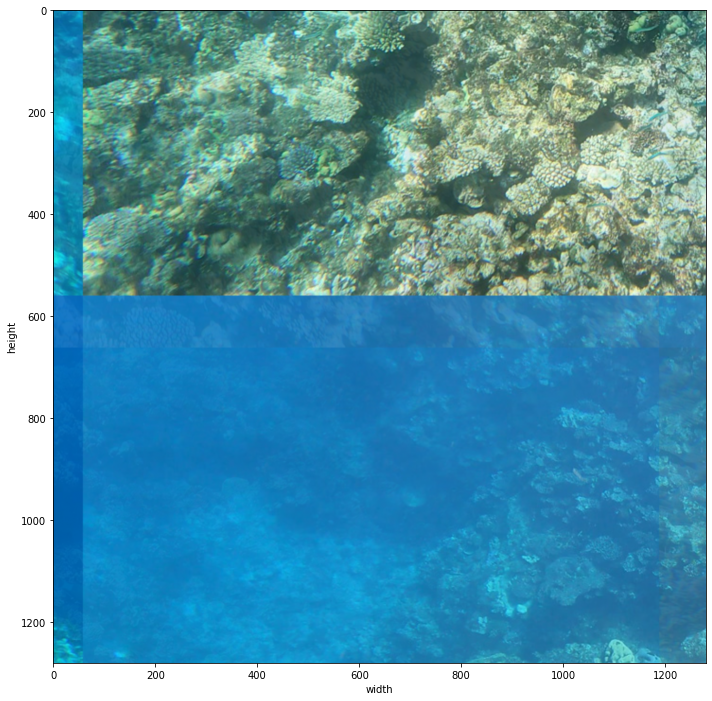

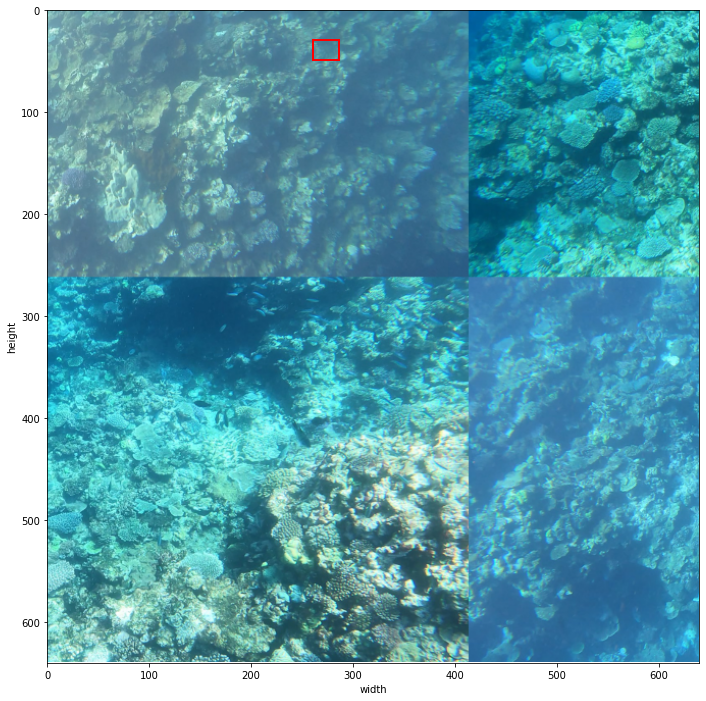

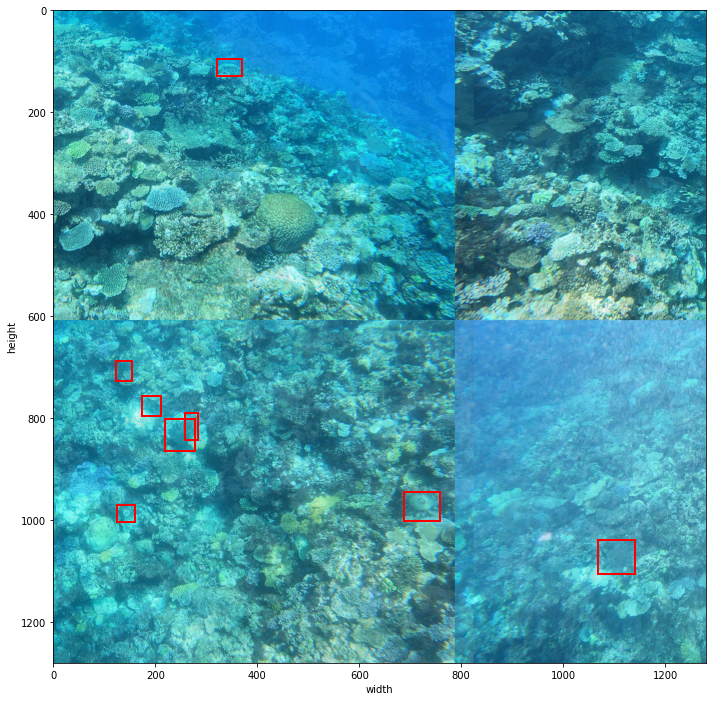

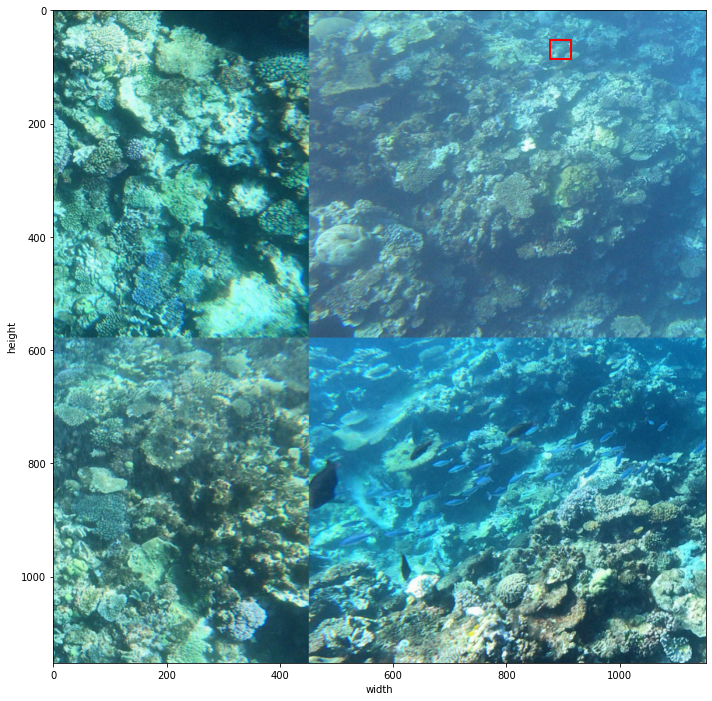

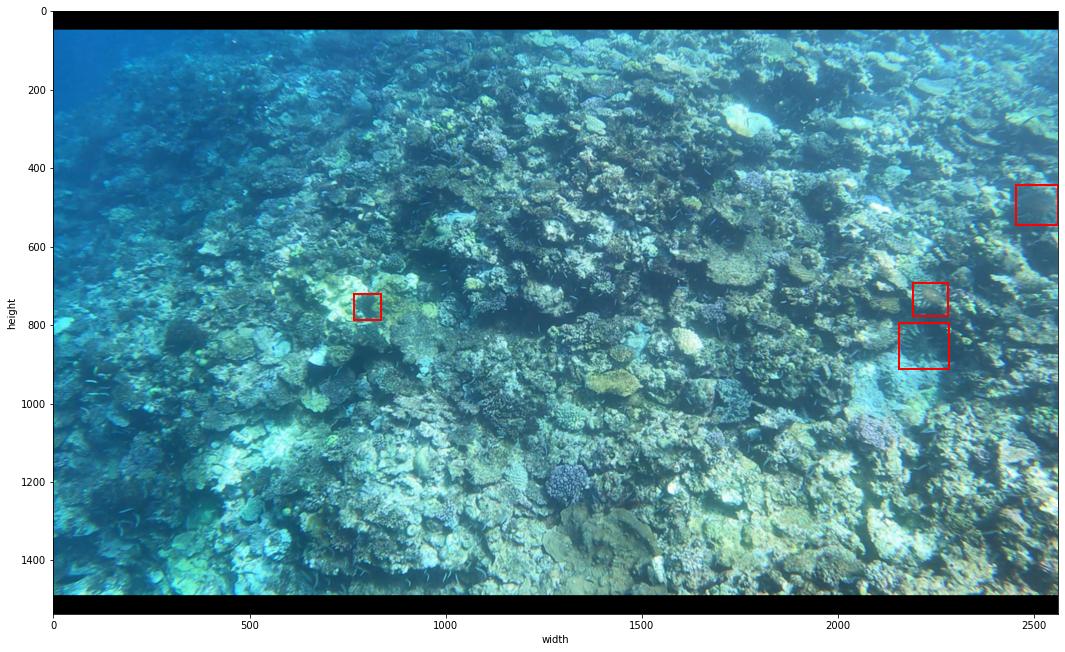

In [31]:
from collections import Counter

def sample_data_gen(data_gen, n_images=5, use_most=True):
    data_gen.on_epoch_end()
    for items in [data_gen[i] for i in range(n_images)]:
        images, all_labels = items[:2]
        
        all_labels = all_labels.numpy()
        label_counts = Counter(all_labels[:, 0].tolist())
        top = label_counts.most_common(1)
        if top and use_most:
            selected_index = int(top[0][0])
        else:
            selected_index = random.choice(list(range(len(images))))

        img = images[selected_index]
        labels = all_labels[all_labels[:, 0] == selected_index]
        shape = img.shape[:2][::-1]
        boxes = [yolo2coco(l, shape) for l in labels[:, 2:]]
        show_norm_img(img, None, None, boxes, plain=True)
        
def sample_train_and_test():
    fold = 0
    train = df_kfold[df_kfold['fold'] != fold]
    test = df_kfold[df_kfold['fold'] == fold]
    train_gen = CotsTrainingDataGen(
        train,
        img_size=1280, # Square image size that images will be loaded at.
        batch_size=2,
        wh0=(1280, 720), # Original image size.
        cache_size_gb=0.05,
        rescale_cadence=1,
        parallel=True,
        augment=True,
        hyp=HYPER_PARAMS
    )
    
    test_gen = CotsTestDataGen(
        test,
        img_size=2560, # Square image size that images will be loaded at.
        batch_size=4,
        shuffle=True,
        wh0=(1280, 720), # Original image size.
        hyp=HYPER_PARAMS
    )

    t0 = time.perf_counter()
    
    sample_data_gen(train_gen, 4, False)
    print('Training sampling took:', time.perf_counter() - t0, 'sec')
    sample_data_gen(test_gen, 1)

sample_train_and_test()

# So now we can train, right?

Yep! Let's create our training loop :D

First we need some utilities for evaluation.

### NMS

In [32]:
def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(tf.transpose(box1))
    area2 = box_area(tf.transpose(box2))

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (tf.math.minimum(box1[:, None, 2:], box2[:, 2:]) - tf.math.maximum(box1[:, None, :2], box2[:, :2]))
    inter = tf.clip_by_value(inter, 0, 10000)
    inter = tf.reduce_prod(inter, axis=2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

def box_iou_np(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(box1.T)
    area2 = box_area(box2.T)

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (np.maximum(box1[:, None, 2:], box2[:, 2:]) - np.maximum(box1[:, None, :2], box2[:, :2])).clip(0).prod(2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

def non_max_suppression(prediction, conf_thr=0.1, iou_thr=0.6, merge=False, agnostic=False):
    # Input shape: (cx, cy, w, h, conf, cls...)
    # Output shape: (x1, y1, x2, y2, conf, cls)
    dtype = prediction.dtype
    nc = prediction[0].shape[1] - 5
    xc = prediction[..., 4] > conf_thr  # candidates
    
    iou_thr = tf.constant(iou_thr, dtype=dtype)
    conf_thr = tf.constant(conf_thr, dtype=dtype)
    score_thr = tf.constant(float('-inf'), dtype=dtype)

    min_wh, max_wh = 2, 4096
    max_det = tf.constant(300, dtype=tf.int32)
    time_limit = 5 # seconds to quit after
    redundant = True
    
    t = time.perf_counter()
    output = []
    for xi, x in enumerate(prediction):
        x = x[xc[xi]]
        
        if not x.shape[0]:
            output.append(tf.zeros((0, 6), dtype=dtype))
            continue
        
        x_boxobj = x[:, :5]
        x_confs = x[:, 5:5+nc] * tf.tile(x_boxobj[:, 4][:, None], (1, x[:, 5:].shape[1]))
        x = tf.concat([x_boxobj, x_confs], -1)
        
        box = cxywh2xyxy(x[:, :4])
        j = tf.math.argmax(x[:, 5:5+nc], 1)
        j_gather_index = tf.stack((tf.range(x.shape[0], dtype=tf.int64), j), 1)
        
        conf = tf.gather_nd(x[:, 5:5+nc], j_gather_index)[:, None]
        conf_filter = tf.reshape(conf, -1) > conf_thr
        x = tf.concat([box, conf, tf.cast(j[:, None], dtype=dtype)], 1)[conf_filter]
        
        n = x.shape[0]
        if not n:
            output.append(tf.zeros((0, 6), dtype=dtype))
            continue
            
        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        selected_indices = tf.image.non_max_suppression(boxes, scores, max_det, iou_threshold=iou_thr, score_threshold=score_thr)
        selected_boxes = tf.gather(boxes, selected_indices)
        if merge and (1 < n < 3e3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = tf.cast(box_iou(selected_boxes, boxes) > iou_thr, dtype=dtype)  # iou matrix
            weights = iou * scores[None]  # box weights
            l = tf.linalg.matmul(weights, x[:, :4]) / tf.reduce_sum(weights, 1, keepdims=True)  # merged boxes

            if redundant:
                selected_indices = selected_indices[tf.reduce_sum(iou, 1) > 1]  # require redundancy
            
            if selected_indices.shape[0]:
                r = tf.gather(x[:, 4:], selected_indices)
                x = tf.concat((l, r), 1)
            else:
                x = tf.zeros((0, 6))
        else:
            x = tf.gather(x, selected_indices)
        
        if (time.perf_counter() - t) > time_limit:
            break  # time limit exceeded
       
        output.append(x)
    
    return output

def demo_nms():
    shape = (4, 4, 6)
    inputs = tf.reshape(tf.range(np.prod(shape), dtype=tf.float32), shape) / 2
    inputs = tf.cast(inputs, tf.float16)
    print(inputs.dtype)
    # inputs = tf.zeros(shape)
    result = non_max_suppression(inputs, merge=False)
    print('====')
    print(*result, sep='\n')

# result = demo_nms()

In [33]:
from PIL import Image

def clip_coords(boxes, img_shape):
    items = []
    for i in range(4):
        upper = img_shape[(i + 1) % 2]
        items.append(tf.clip_by_value(boxes[:, i], 0, upper))
    
    for i in range(4, boxes.shape[1]):
        items.append(boxes[:, i])
    
    return tf.stack(items, 1)


def scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    first_dim = list(range(len(coords)))
    
    updates = tf.constant((pad[0], pad[1], pad[0], pad[1]), dtype=coords.dtype)
    l = coords[:, :4] - updates
    l = l[:, :4] / gain
    l = clip_coords(l, img0_shape)
    r = coords[:, 4:]
    return tf.concat((l, r), 1)


def color_list():
    # Return first 10 plt colors as (r,g,b) https://stackoverflow.com/questions/51350872/python-from-color-name-to-rgb
    def hex2rgb(h):
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))

    return [hex2rgb(h) for h in plt.rcParams['axes.prop_cycle'].by_key()['color']]

def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tft = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tft)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tft, lineType=cv2.LINE_AA)

        
def output_to_target(output, width, height):
    # Convert model output to target format [batch_id, class_id, x, y, w, h, conf]
    if tf.is_tensor(output):
        output = output.numpy()

    targets = []
    for i, o in enumerate(output):
        if o is not None:
            for pred in o:
                box = pred[:4]
                w = (box[2] - box[0]) / width
                h = (box[3] - box[1]) / height
                x = box[0] / width + w / 2
                y = box[1] / height + h / 2
                conf = pred[4]
                cls = int(pred[5])
                
                o = [i, cls, x, y, w, h, conf]

                targets.append(o)

    return np.array(targets)


def plot_images(images, targets, paths=None, fname='images.jpg', names=None, max_size=640, max_subplots=16, denorm=None):
    # Plot image grid with labels
    
    # un-normalise
    images = denorm(images)

    if tf.is_tensor(images):
        images = images.numpy().astype(np.float32)
    if tf.is_tensor(targets):
        targets = targets.numpy()

    tl = 3  # line thickness
    tft = max(tl - 1, 1)  # font thickness
    bs, _, h, w = images.shape  # batch size, _, height, width
    bs = min(bs, max_subplots)  # limit plot images
    ns = np.ceil(bs ** 0.5)  # number of subplots (square)

    # Check if we should resize
    scale_factor = max_size / max(h, w)
    if scale_factor < 1:
        h = math.ceil(scale_factor * h)
        w = math.ceil(scale_factor * w)

    colors = color_list()  # list of colors
    mosaic = np.full((int(ns * h), int(ns * w), 3), 255, dtype=np.uint8)  # init
    for i, img in enumerate(images):
            
        if i == max_subplots:  # if last batch has fewer images than we expect
            break

        block_x = int(w * (i // ns))
        block_y = int(h * (i % ns))

        img = img.transpose(1, 2, 0)
        if scale_factor < 1:
            img = cv2.resize(img, (w, h))

        mosaic[block_y:block_y + h, block_x:block_x + w, :] = img
        if len(targets) > 0:
            image_targets = targets[targets[:, 0] == i]
            boxes = cxywh2xyxy(image_targets[:, 2:6], mode='np').T
            classes = image_targets[:, 1].astype('int')
            labels = image_targets.shape[1] == 6  # labels if no conf column
            conf = None if labels else image_targets[:, 6]  # check for confidence presence (label vs pred)

            boxes[[0, 2]] *= w
            boxes[[0, 2]] += block_x
            boxes[[1, 3]] *= h
            boxes[[1, 3]] += block_y
            for j, box in enumerate(boxes.T):
                cls = int(classes[j])
                color = colors[cls % len(colors)]
                cls = names[cls] if names else cls
                if labels or conf[j] > 0.001:  # 0.25 conf thresh
                    if not labels:
                        color = tuple([int(conf[j] * 255 / max(conf)) for _ in range(3)])
                    label = '%s' % cls if labels else '%s %.1f' % (cls, conf[j])
                    plot_one_box(box, mosaic, label=label, color=color, line_thickness=tl)

        # Draw image filename labels
        if paths:
            label = Path(paths[i]).name[:40]  # trim to 40 char
            t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tft)[0]
            cv2.putText(mosaic, label, (block_x + 5, block_y + t_size[1] + 5), 0, tl / 3, [220, 220, 220], thickness=tft,
                        lineType=cv2.LINE_AA)

        # Image border
        cv2.rectangle(mosaic, (block_x, block_y), (block_x + w, block_y + h), (255, 255, 255), thickness=3)

    if fname:
        r = min(1280. / max(h, w) / ns, 1.0)  # ratio to limit image size
        mosaic = cv2.resize(mosaic, (int(ns * w * r), int(ns * h * r)), interpolation=cv2.INTER_AREA)
        # cv2.imwrite(fname, cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))  # cv2 save
        Image.fromarray(mosaic).save(fname)  # PIL save
    return mosaic

def fitness(x):
    # Model fitness as a weighted combination of metrics
    w = [0.0, 0.0, 0.1, 0.9]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return (x[:, :4] * w).sum(1)


def fitness_p(x):
    # Model fitness as a weighted combination of metrics
    w = [1.0, 0.0, 0.0, 0.0]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return (x[:, :4] * w).sum(1)


def fitness_r(x):
    # Model fitness as a weighted combination of metrics
    w = [0.0, 1.0, 0.0, 0.0]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return (x[:, :4] * w).sum(1)


def fitness_ap50(x):
    # Model fitness as a weighted combination of metrics
    w = [0.0, 0.0, 1.0, 0.0]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return (x[:, :4] * w).sum(1)


def fitness_ap(x):
    # Model fitness as a weighted combination of metrics
    w = [0.0, 0.0, 0.0, 1.0]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return (x[:, :4] * w).sum(1)


def fitness_f(x):
    # Model fitness as a weighted combination of metrics
    #w = [0.0, 0.0, 0.0, 1.0]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return ((x[:, 0]*x[:, 1])/(x[:, 0]+x[:, 1]))


def fitness_f2(x):
    # Model fitness as a weighted combination of metrics
    #w = [0.0, 0.0, 0.0, 1.0]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return x[:, 5]

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = 'interp'  # methods: 'continuous', 'interp'
    if method == 'interp':
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec


def ap_per_class(tp, conf, pred_cls, target_cls, plot=False, fname='precision-recall_curve.png'):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:  True positives (nparray, nx1 or nx10).
        conf:  Objectness value from 0-1 (nparray).
        pred_cls:  Predicted object classes (nparray).
        target_cls:  True object classes (nparray).
        plot:  Plot precision-recall curve at mAP@0.5
        fname:  Plot filename
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    px, py = np.linspace(0, 1, 1000), []  # for plotting
    pr_score = 0.1  # score to evaluate P and R https://github.com/ultralytics/yolov3/issues/898
    s = [unique_classes.shape[0], tp.shape[1]]  # number class, number iou thresholds (i.e. 10 for mAP0.5...0.95)
    ap, p, r = np.zeros(s), np.zeros(s), np.zeros(s)
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_l = (target_cls == c).sum()  # number of labels
        n_p = i.sum()  # number of predictions

        if n_p == 0 or n_l == 0:
            continue
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum(0)
            tpc = tp[i].cumsum(0)

            # Recall
            recall = tpc / (n_l + 1e-16)  # recall curve
            r[ci] = np.interp(-pr_score, -conf[i], recall[:, 0])  # r at pr_score, negative x, xp because xp decreases

            # Precision
            precision = tpc / (tpc + fpc)  # precision curve
            p[ci] = np.interp(-pr_score, -conf[i], precision[:, 0])  # p at pr_score

            # AP from recall-precision curve
            for j in range(tp.shape[1]):
                ap[ci, j], mpre, mrec = compute_ap(recall[:, j], precision[:, j])
                if j == 0:
                    py.append(np.interp(px, mrec, mpre))  # precision at mAP@0.5

    # Compute F2 score -- https://en.wikipedia.org/wiki/F-score
    f2 = 5 * p * r / ((4 * p) + r + 1e-16)

    if plot:
        py = np.stack(py, axis=1)
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.plot(px, py, linewidth=0.5, color='grey')  # plot(recall, precision)
        ax.plot(px, py.mean(1), linewidth=2, color='blue', label='all classes %.3f mAP@0.5' % ap[:, 0].mean())
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        plt.legend()
        fig.tight_layout()
        fig.savefig(fname, dpi=200)

    return p, r, ap, f2, unique_classes.astype('int32')


def test(
    weights=None,
    norm=None,
    denorm=None,
    imgsz=640,
    conf_thr=0.01,
    iou_thr=0.4,
    verbose=False,
    model=None,
    anchors=None,
    strides=None,
    loader=None,
    save_dir=Path(''),
    save_txt=False,
    save_conf=False,
    plots=True,
    log_imgs=0,
    hyp=None,
    debug=False
):
    training = model is not None
    nc = 1
    iouv = tf.linspace(0.5, 0.95, 10)
    niou = len(iouv)
    
    log_imgs, wandb = min(log_imgs, 100), None
    # TODO wandb import
    
    seen = 0
    names = ('cots',)
    
    s = ('%20s' + '%12s' * 7) % ('Class', 'Images', 'Targets', 'P', 'R', 'F2', 'mAP@.5', 'mAP@.5:.95')
    p, r, f2, mp, mr, mf2, _map50, _map, t0, t1 = 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.
    loss = tf.zeros(3)
    jdict, stats, ap, ap_class, wandb_images = [], [], [], [], []
    
    debug_batches = 5
    total_items = loader.max_items if not debug else debug_batches * loader.batch_size
    
    for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(loader, desc=s)):
        img = norm(img)
        nb, _, height, width = img.shape
        whwh = tf.constant([width, height, width, height], dtype=K.floatx())

        t = time.perf_counter()
        inf_out, train_out = model(img, training=False)
        t0 += time.perf_counter() - t
        
        if training:
            loss += compute_loss([x for x in train_out], targets, anchors, strides, hyp)[1][:3]
        
        t = time.perf_counter()
        output = non_max_suppression(inf_out, conf_thr=conf_thr, iou_thr=iou_thr)
        t1 += time.perf_counter() - t
        
        targets_np = targets.numpy()
        
        for si, pred in enumerate(output):
            labels = targets_np[targets_np[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []
            seen += 1
            
            if len(pred) == 0:
                if nl:
                    stats.append((np.zeros((0, niou), dtype=np.bool), np.array([]), np.array([]), tcls))
                    pass
                continue
            
            # Append to text file
            path = Path(paths[si])
            if save_txt:
                gn = np.array(shapes[si][0])[[1, 0, 1, 0]] # normalization gain whwh
                x = pred
                l = scale_coords(img[si].shape[1:], x[:, :4], shapes[si][0], shapes[si][1])  # to original
                r = x[:, 4:]
                x = tf.concat((l, r), 1)
                for *xyxy, conf, cls in x:
                    xyxy = np.array([xyxyi.numpy().item() for xyxyi in xyxy]).reshape((1, 4))
                    xywh = xyxy2cxywh(xyxy / gn, mode='np').flatten().tolist()  # normalized xywh
                    line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                    (save_dir / 'labels').mkdir(exist_ok=True)
                    with open(save_dir / 'labels' / (path.stem + '.txt'), 'a') as f:
                        f.write(('%g ' * len(line)).rstrip() % line + '\n')
            
            # W&B logging
            if (wandb is not None) and plots and len(wandb_images) < log_imgs:
                box_data = [
                    {
                        "position": {
                            "minX": xyxy[0], "minY": xyxy[1], "maxX": xyxy[2], "maxY": xyxy[3]
                        },
                        "class_id": int(cls),
                        "box_caption": "%s %.3f" % (names[cls], conf),
                        "scores": {"class_score": conf},
                        "domain": "pixel"
                    } for *xyxy, conf, cls in pred.tolist()
                ]
                boxes = {"predictions": {"box_data": box_data, "class_labels": names}}
                wandb_images.append(wandb.Image(img[si], boxes=boxes, caption=path.name))
            
            pred = clip_coords(pred, (height, width))
            pred_np = pred.numpy()
            
            correct = np.zeros((pred.shape[0], niou), dtype=np.bool)
            if nl:
                detected = []
                tcls_tensor = labels[:, 0]
                tbox = cxywh2xyxy(labels[:, 1:5]) * whwh
                
                # Per target class
                for cls in np.unique(tcls_tensor):
                    ti = (cls == tcls_tensor)
                    pi = (cls == pred_np[:, 5])
                    ti = np.flatnonzero(ti)  # prediction indices
                    pi = np.flatnonzero(pi)  # target indices

                    # Search for detections
                    if pi.shape[0]:
                        # Prediction to target ious
                        ious = box_iou_np(pred_np[pi, :4], tbox.numpy()[ti])
                        i = ious.argmax(1)  # best ious, indices
                        ious = np.take_along_axis(ious, np.expand_dims(i, axis=1), axis=1)

                        # Append detections
                        detected_set = set()
                        js = (ious > iouv[0].numpy())
                        js = np.flatnonzero(js)
                        for j in js:
                            d = ti[i[j]]  # detected target
                            if d.item() not in detected_set:
                                detected_set.add(d.item())
                                detected.append(d)
                                correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                                if len(detected) == nl:  # all targets already located in image
                                    break
                
                
            # Append statistics (correct, conf, pcls, tcls)
            stats.append((correct, pred[:, 4].numpy(), pred[:, 5].numpy(), tcls))

        # Plot images
        if plots and batch_i < 3:
            f = save_dir / f'test_batch{batch_i}_labels.jpg'  # filename
            plot_images(img, targets, paths, f, names, denorm=denorm)  # labels
            f = save_dir / f'test_batch{batch_i}_pred.jpg'
            plot_images(img, output_to_target(output, width, height), paths, f, names, denorm=denorm)  # predictions                                
        
        if debug and batch_i >= debug_batches:
            break

    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        p, r, ap, f2, ap_class = ap_per_class(*stats, plot=plots, fname=save_dir / 'precision-recall_curve.png')
        p, r, ap50, ap, f2 = p[:, 0], r[:, 0], ap[:, 0], ap.mean(1), f2[:, 0]  # [P, R, AP@0.5, AP@0.5:0.95]
        mp, mr, _map50, _map, mf2 = p.mean(), r.mean(), ap50.mean(), ap.mean(), f2.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = np.zeros(1)

    # W&B logging
    if plots and wandb:
        wandb.log({"Images": wandb_images})
        wandb.log({"Validation": [wandb.Image(str(x), caption=x.name) for x in sorted(save_dir.glob('test*.jpg'))]})

    # Print results
    pf = '%20s' + '%12.3g' * 7  # print format
    print(pf % ('all', seen, nt.sum(), mp, mr, mf2, _map50, _map))

    # Print results per class
    if verbose and nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            print(pf % (names[c], seen, nt[c], p[i], r[i], f2[i], ap50[i], ap[i]))

    # Print speeds
    t = tuple(x / seen * 1e3 for x in (t0, t1, t0 + t1)) + (imgsz, imgsz, loader.batch_size)  # tuple
    if not training:
        print('Speed: %.1f/%.1f/%.1f ms inference/NMS/total per %gx%g image at batch-size %g' % t)
        
    # Return results
    if not training:
        print('Results saved to %s' % save_dir)
    maps = np.zeros(nc) + _map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]
    return (mp, mr, _map50, _map, mf2, *(loss.numpy() / total_items).tolist()), maps, t

## Create the Core Training Loop

Maybe TODO:
- Checkpoint support

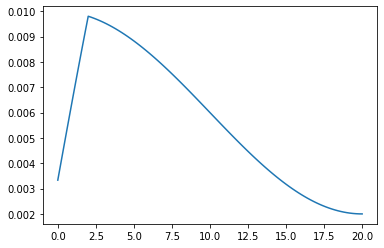

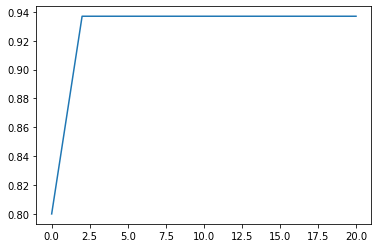

In [34]:
import json
import yaml

def is_half_precision():
    policy_name = keras.mixed_precision.global_policy().name
    return policy_name == 'mixed_float16'

def create_train_step(model, anchors, strides, optimizer, hyp):
    model_f = tf.function(model)
    
    print('Creating training step function.')
    print('Using anchors:')
    print('\n'.join(map(lambda s: '  ' + str(s), anchors)))
    print('With strides:', strides)

    print('Using optimizer:', optimizer)
    if is_half_precision():
        print('Using half-precision.')
    
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            outputs = model_f(inputs, training=True)
            loss, loss_parts = compute_loss(outputs, targets, anchors, strides, hyp)
            if is_half_precision():
                scaled_loss = optimizer.get_scaled_loss(loss)
                loss_parts = optimizer.get_scaled_loss(loss_parts)
            else:
                scaled_loss = loss

        scaled_grads = tape.gradient(scaled_loss, model.trainable_weights)
        if is_half_precision():
            grads = optimizer.get_unscaled_gradients(scaled_grads)
        else:
            grads = scaled_grads

        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        return scaled_loss, loss_parts

    return train_step


def create_lr_scheduler(epochs, warmup_epochs, lr0, lrf):
    
    def lr(x):
        rate = ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - lrf) + lrf
        if x <= warmup_epochs:
            a = (x + 1) / (warmup_epochs + 1)
        else:
            a = 1
        
        return lr0 * a * rate
    
    return lr

def create_momentum_scheduler(epochs, warmup_epochs, m0, mf):
    
    def momentum(x):
        if x < warmup_epochs:
            rate = x / warmup_epochs
            return m0 + (mf - m0) * rate
        else:
            return mf
    
    return momentum

def create_norm(norm_type, channels_first):
    if norm_type == 'cots':
        mean = tf.constant([0.22160156, 0.60840114, 0.65382148])
        std = tf.constant([0.17279742, 0.17416202, 0.16197856])
        if channels_first:
            mean = mean[:, None, None]
            std = std[:, None, None]
        return lambda x: (tf.cast(x, K.floatx()) - mean) / std
    elif norm_type == 'global':
        mean = tf.constant([0.26522878, 0.57244527, 0.61950165])
        std = tf.constant([0.21550692, 0.19170376, 0.19790073])
        if channels_first:
            mean = mean[:, None, None]
            std = std[:, None, None]
        return lambda x: (tf.cast(x, K.floatx()) - mean) / std
    else:
        if norm_type is not None:
            print('Invalid norm type:', norm_type)
    
        return lambda x: tf.cast(x, K.floatx()) / 255.0

def create_denorm(norm_type, channels_first):
    if norm_type == 'cots':
        mean = tf.constant([0.22160156, 0.60840114, 0.65382148])
        std = tf.constant([0.17279742, 0.17416202, 0.16197856])
        if channels_first:
            mean = mean[:, None, None]
            std = std[:, None, None]
        return lambda x: tf.cast(x, K.floatx()) * std + mean
    elif norm_type == 'global':
        mean = tf.constant([0.26522878, 0.57244527, 0.61950165])
        std = tf.constant([0.21550692, 0.19170376, 0.19790073])
        if channels_first:
            mean = mean[:, None, None]
            std = std[:, None, None]
        return lambda x: tf.cast(x, K.floatx()) * std + mean
    else:
        if norm_type is not None:
            print('Invalid norm type:', norm_type)
    
        return lambda x: tf.cast(x, K.floatx()) * 255.0


def init_model(model, img_size, channels_first):
    init_shape = (1, 3, img_size, img_size) if channels_first else (1, img_size, img_size, 3)
    model(tf.zeros(init_shape))

def get_model_anchor_info(model):
    anchors = []
    strides = []
    for l in model.head.layers:
        if isinstance(l, YoloLayer):
            anchors.append(l.anchors.numpy().astype(int).tolist())
            strides.append(l.stride)
    
    return anchors, strides

def train(
    model, opt, train_gen, test_gen, epochs, hyp,
    start_epoch=0,
    save_file='model/saved_model',
    debug=False
):
    save_dir = Path('outputs')
    save_dir.mkdir(parents=True, exist_ok=True)
    results_file = save_dir / 'results.txt'
    
    anchors, strides = get_model_anchor_info(model)
    
    with open(save_dir / 'hyp.yaml', 'w') as f:
        yaml.dump(hyp, f)
    
    train_step = create_train_step(model, anchors, strides, opt, hyp)
    
    train_gen.on_epoch_end()
    test_gen.on_epoch_end()
    nb = len(train_gen)
    
    lr0 = hyp.get('lr0', 0.01)
    lrf = hyp.get('lrf', 0.2)
    m0 = hyp.get('warmup_momentum', 0.8)
    mf = hyp.get('momentum', 0.937)
    warmup_eps = hyp.get('warmup_epochs', 1)
    t0 = time.time()
    nw = max(round(warmup_eps * nb), 1000)
    maps = np.zeros(1)
    results = (0, 0, 0, 0, 0, 0, 0, 0)
    
    lr_schedule = create_lr_scheduler(epochs, warmup_eps, lr0, lrf)
    m_schedule = create_momentum_scheduler(epochs, warmup_eps, m0, mf)
    
    def update_opt(ep):
        new_lr = lr_schedule(ep)
        new_m = m_schedule(ep)
        opt.learning_rate.assign(new_lr)
        
        if isinstance(opt, keras.optimizers.SGD):
            opt.momentum.assign(new_m)
        elif isinstance(opt, keras.optimizers.Adam):
            opt.beta_1.assign(new_m)
        else:
            raise ValueError(f'Unsupported optimizer: {type(opt)}')
        
        if ep % 1 == 0:
            print('Setting LR:', new_lr)
            print('Setting momentum:', new_m)
    
    norm_type = hyp.get('normalize', None)
    norm = create_norm(norm_type, model.data_format == 'channels_first')
    denorm = create_denorm(norm_type, model.data_format == 'channels_first')
    
    best_fitness = 0.0
    best_fitness_f2 = 0.0
    best_fitness_p, best_fitness_r, best_fitness_ap50, best_fitness_ap, best_fitness_f = 0.0, 0.0, 0.0, 0.0, 0.0
    
    print(f'Training for {epochs} eps with {warmup_eps} for warmup.')
    
    init_augment = train_gen.augment
    
    for epoch in range(start_epoch, epochs):
        update_opt(epoch)
        mloss = tf.zeros(4)
        
        final_epoch = epoch + 1 == epochs
        if final_epoch:
            train_gen.augment = False
        
        print(('\n' + '%10s' * 5) % ('Epoch', 'box', 'obj', 'total', 'targets'))
        nb = len(train_gen)
        pbar = tqdm(enumerate(train_gen), total=nb)
        for i, (imgs, targets) in pbar:
            imgs = norm(imgs)
            ni = i + nb * epoch
            
            if ni <= nw:
                partial_ep = ni / nb
                update_opt(partial_ep)
            
            loss, loss_items = train_step(imgs, targets)
            
            mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
            lbox, lobj, _, ltotal = mloss
            s = ('%10s' + '%10.4g' * 4) % ('%g/%g' % (epoch, epochs - 1), lbox, lobj, ltotal, targets.shape[0])
            pbar.set_description(s)
        
        # End Epoch
        print('Epoch ended.')
        train_gen.on_epoch_end()
        test_gen.on_epoch_end()
        
        epoch_dir = Path('') if final_epoch else Path(f'epoch-{epoch}')
        epoch_dir.mkdir(exist_ok=True)

        is_intermediate = epoch % 4 == 0 and epoch > 0
        if final_epoch or is_intermediate:  # Calculate mAP
            results, maps, times = test(
                imgsz=test_gen.img_size,
                model=model,
                anchors=anchors,
                strides=strides,
                norm=norm,
                denorm=denorm,
                loader=test_gen,
                plots=True,
                save_txt=True,
                hyp=hyp,
                debug=debug,
                save_dir=epoch_dir,
            )
        
            # Write
            with open(results_file, 'a') as f:
                f.write(s + '%10.4g' * 8 % results + '\n')  # P, R, mAP@.5, mAP@.5-.95, F2, val_loss(box, obj, cls)

            # Update best mAP
            results_arr = np.array(results).reshape(1, -1)
            fi = fitness(results_arr)  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            fi_p = fitness_p(results_arr)  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            fi_r = fitness_r(results_arr)  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            fi_ap50 = fitness_ap50(results_arr)  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            fi_ap = fitness_ap(results_arr)  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            if (fi_p > 0.0) or (fi_r > 0.0):
                fi_f = fitness_f(results_arr)  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            else:
                fi_f = 0.0
            if fi > best_fitness:
                best_fitness = fi
            if fi_p > best_fitness_p:
                best_fitness_p = fi_p
            if fi_r > best_fitness_r:
                best_fitness_r = fi_r
            if fi_ap50 > best_fitness_ap50:
                best_fitness_ap50 = fi_ap50
            if fi_ap > best_fitness_ap:
                best_fitness_ap = fi_ap
            if fi_f > best_fitness_f:
                best_fitness_f = fi_f

            # Save model
            if final_epoch:
                with open(results_file, 'r') as f:  # create checkpoint
                    ckpt = {
                        'epoch': epoch,
                        'best_fitness': best_fitness,
                        'best_fitness_p': best_fitness_p,
                        'best_fitness_r': best_fitness_r,
                        'best_fitness_ap50': best_fitness_ap50,
                        'best_fitness_ap': best_fitness_ap,
                        'best_fitness_f': best_fitness_f,
                        'training_results': f.read(),
                    }

#                 with open(save_dir / 'model-meta.json', 'w+') as mm:
#                     json.dump(ckpt, mm)

            model.save_weights(save_dir / f'{save_file}-e{epoch}')
            
    train_gen.augment = init_augment

def demo_lr_schedule(lr0, lrf, epochs, warmup_eps):
    lr_schedule = create_lr_scheduler(epochs, warmup_eps, lr0, lrf)
    delta = 0.2
    x = np.arange(0, epochs + delta, delta)
    y = [lr_schedule(xi) for xi in x]

    plt.figure()
    plt.plot(x, y)
    
def demo_momentum_schedule(m0, mf, epochs, warmup_eps):
    m_schedule = create_momentum_scheduler(epochs, warmup_eps, m0, mf)
    delta = 0.2
    x = np.arange(0, epochs + delta, delta)
    y = [m_schedule(xi) for xi in x]

    plt.figure()
    plt.plot(x, y)
        
demo_lr_schedule(lr0=0.01, lrf=0.2, epochs=20, warmup_eps=2)
demo_momentum_schedule(m0=0.8, mf=0.937, epochs=20, warmup_eps=2)

In [36]:
HYPER_PARAMS = {
    # Training
    'warmup_epochs': 3,
    'lr0': 0.001,
    'lrf': 0.2,
    'momentum': 0.949,
    'normalize': None,
    
    # Anchors
    'anchor_t': 4.0, # maximum allowed w/h or h/w ratio for boxes
    
    # Loss
    'fl_gamma': 0.0, # focal loss gamma (multi-class only)
    'sbce_eps': 0.0, # epsilon for BCE smoothing (multi-class only)
    'box': 0.05, # box loss gain
    'cls': 0.5, # class loss gain (multi-class only)
    'obj': 1.0, # objectness loss gain

    # Augmentation
    'fliplr': 0.5, # probability of a random l/r flip in training
    'full_scale': 0.125,
    'degrees': 5.0,
    'translate': 0.2,
    'scale': 0.2,
    'blur_any': 0.1,
    'contrast': 0.1,
    'mosaic': 0.9,
    'mixup': 0.3,
    'hsv': 0.2,
    'hsv_h': 0.015,
    'hsv_s': 0.05,
    'hsv_v': 0.05,
    'gray': 0.025
}

def create_data_gen(
    df, split, channels_first, hyp,
    batch_sizes=(4, 8),
    img_size=1280,
    cache_size_gb=1
):
    train_batch, test_batch = batch_sizes
    
    train = df[df['fold'] != split]
    test = df[df['fold'] == split]
    
    wh0 = (1280, 720) # All input images are this size by default.
    train_gen = CotsTrainingDataGen(
        train,
        img_size=img_size, # Square image size that images will be loaded at.
        batch_size=train_batch,
        wh0=wh0, # Original image size.
        cache_size_gb=cache_size_gb,
        parallel=True,
        augment=True,
        is_channels_first=channels_first,
        hyp=hyp
    )
    
    test_gen = CotsTestDataGen(
        test,
        img_size=img_size, # Square image size that images will be loaded at.
        batch_size=test_batch,
        shuffle=True,
        wh0=wh0, # Original image size.
        is_channels_first=channels_first,
        hyp=hyp
    )
    
    return train_gen, test_gen

img_size = 1280
has_gpu = len(GPUS) > 0
split = 7
train_gen, test_gen = create_data_gen(
    df_kfold,
    split=split,
    channels_first=has_gpu,
    hyp=HYPER_PARAMS,
    batch_sizes=(2, 4),
    img_size=img_size,
    cache_size_gb=12
)

Caching up to 4340 images of 20546 total.
Caching 4340 positive images.


100%|██████████| 4339/4339 [01:41<00:00, 42.62it/s]


In [37]:
yolor = YolorP6(1, anchors=ALL_ANCHORS, data_format=DATA_FORMAT)

init_model(yolor, img_size, channels_first=has_gpu)

OPT = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.8, beta_2=0.999)
if is_half_precision():
    OPT = keras.mixed_precision.LossScaleOptimizer(OPT)

In [38]:
!rm -r labels
!rm *.jpg
!rm *.png
!mkdir labels

rm: cannot remove 'labels': No such file or directory
rm: cannot remove '*.jpg': No such file or directory
rm: cannot remove '*.png': No such file or directory


Creating training step function.
Using anchors:
  [[19, 27], [44, 40], [38, 94]]
  [[96, 68], [86, 152], [180, 137]]
  [[140, 301], [303, 264], [238, 542]]
  [[436, 615], [739, 380], [925, 792]]
With strides: [8, 16, 32, 64]
Using optimizer: <keras.optimizer_v2.adam.Adam object at 0x7f6494faf910>
Training for 10 eps with 3 for warmup.
Setting LR: 0.00025
Setting momentum: 0.8

     Epoch       box       obj     total   targets


  0%|          | 0/2306 [00:00<?, ?it/s]

Setting LR: 0.00025
Setting momentum: 0.8


       0/9   0.04272   0.01233   0.05504         1: 100%|██████████| 2306/2306 [43:58<00:00,  1.14s/it]


Epoch ended.
Setting LR: 0.0004902113032590308
Setting momentum: 0.8496666666666667

     Epoch       box       obj     total   targets


  0%|          | 0/2258 [00:00<?, ?it/s]

Setting LR: 0.0004902113032590308
Setting momentum: 0.8496666666666667


       1/9    0.0368   0.01239   0.04918         5: 100%|██████████| 2258/2258 [39:12<00:00,  1.04s/it]


Epoch ended.
Setting LR: 0.0006927050983124844
Setting momentum: 0.8993333333333333

     Epoch       box       obj     total   targets


  0%|          | 0/2293 [00:00<?, ?it/s]

Setting LR: 0.0006927050983124844
Setting momentum: 0.8993333333333333


       2/9   0.03446   0.01218   0.04663         4: 100%|██████████| 2293/2293 [39:32<00:00,  1.03s/it]


Epoch ended.
Setting LR: 0.0008351141009169894
Setting momentum: 0.949

     Epoch       box       obj     total   targets


       3/9   0.03436   0.01221   0.04657         9: 100%|██████████| 2334/2334 [39:37<00:00,  1.02s/it]


Epoch ended.
Setting LR: 0.0007236067977499789
Setting momentum: 0.949

     Epoch       box       obj     total   targets


       4/9   0.03246   0.01127   0.04374        13: 100%|██████████| 2342/2342 [40:04<00:00,  1.03s/it]


Epoch ended.


               Class      Images     Targets           P           R          F2      mAP@.5  mAP@.5:.95: 100%|██████████| 739/739 [08:52<00:00,  1.39it/s]


                 all    2.96e+03    1.73e+03       0.303       0.266       0.273       0.209        0.19
Setting LR: 0.0006000000000000001
Setting momentum: 0.949

     Epoch       box       obj     total   targets


       5/9   0.02995   0.01082   0.04077        13: 100%|██████████| 2417/2417 [40:31<00:00,  1.01s/it]


Epoch ended.
Setting LR: 0.00047639320225002107
Setting momentum: 0.949

     Epoch       box       obj     total   targets


       6/9   0.02808   0.01022   0.03829         0: 100%|██████████| 2316/2316 [39:26<00:00,  1.02s/it]


Epoch ended.
Setting LR: 0.00036488589908301085
Setting momentum: 0.949

     Epoch       box       obj     total   targets


       7/9   0.02619   0.01033   0.03652        24: 100%|██████████| 1882/1882 [33:46<00:00,  1.08s/it]


Epoch ended.
Setting LR: 0.0002763932022500211
Setting momentum: 0.949

     Epoch       box       obj     total   targets


       8/9   0.02482  0.009264   0.03408         9: 100%|██████████| 2234/2234 [38:26<00:00,  1.03s/it]


Epoch ended.


               Class      Images     Targets           P           R          F2      mAP@.5  mAP@.5:.95: 100%|██████████| 739/739 [11:40<00:00,  1.06it/s]


                 all    2.96e+03    1.73e+03      0.0713       0.591        0.24      0.0727      0.0653
Setting LR: 0.00021957739348193862
Setting momentum: 0.949

     Epoch       box       obj     total   targets


       9/9   0.02101  0.006826   0.02784         6: 100%|██████████| 2412/2412 [29:06<00:00,  1.38it/s]


Epoch ended.


               Class      Images     Targets           P           R          F2      mAP@.5  mAP@.5:.95: 100%|██████████| 739/739 [10:46<00:00,  1.14it/s]


                 all    2.96e+03    1.73e+03      0.0981       0.621         0.3       0.182       0.168


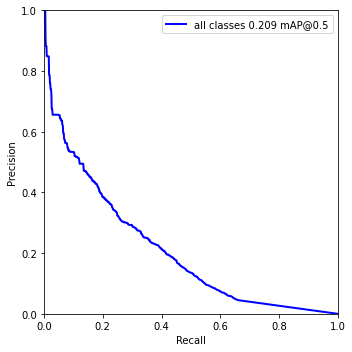

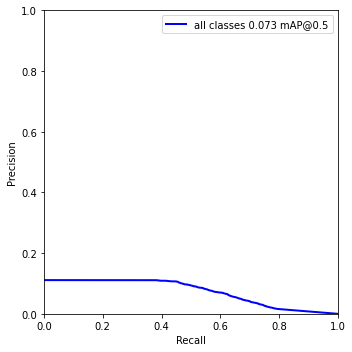

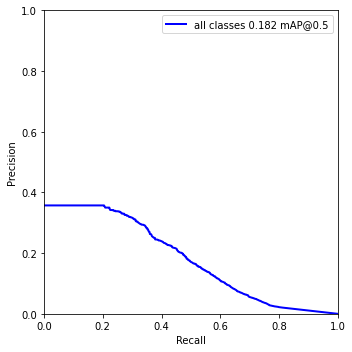

In [39]:
train(
    yolor, OPT, train_gen, test_gen,
    epochs=10,
    hyp=HYPER_PARAMS,
    save_file=f'model/model-split-{split}'
)

# Small net, ep=3/5, wbox=.1, swapped anchors => 0.13, 0.014
# Small net, ep=3/5, wbox=.1, normal anchors => 0.12, 0.014
# Small net, ep=3/5, wbox=.1, cots norm => 0.12, 0.014